In [1]:
import numpy as np
import pandas as pd
## deprecated to 2.2.3 for networkx compatibility
import matplotlib.pyplot as plt
import seaborn as sns
import re

# from sklearn.cluster import KMeans
# from kneed import KneeLocator
# from sklearn.metrics import silhouette_score
# from sklearn.manifold import TSNE

# from sklearn.neighbors import kneighbors_graph
# from scipy import sparse
# import networkx as nx
# from itertools import count
# from scipy import linalg

from utils import import_data, process_data, load_cell, load_drug
from kmeans import find_kmeans, plot_kmeans
from graph import * 
# create_distance, plot_epsilon, create_adjacency, create_graph, add_annotation, create_laplacian, return_graph

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\jessb\anaconda3\envs\math_tools\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
seed = 123
np.random.seed(seed)

# Load and Pre-Process Data

In [3]:
df, mx_gdsc, list_drug, list_cell = import_data()
mx_center, mx_train, idx_val, idx_train, mask_val, mask_train = process_data(mx_gdsc)
df_cell_info = load_cell()
df_drug_info = load_drug(list_drug)

# K-Means Clustering on Centered Data

In [4]:
kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": seed}

kmeans_cell, sse_cell, silhouette_cell = find_kmeans(mx_center, kmeans_kwargs)
kmeans_drug, sse_drug, silhouette_drug = find_kmeans(mx_center.T, kmeans_kwargs)

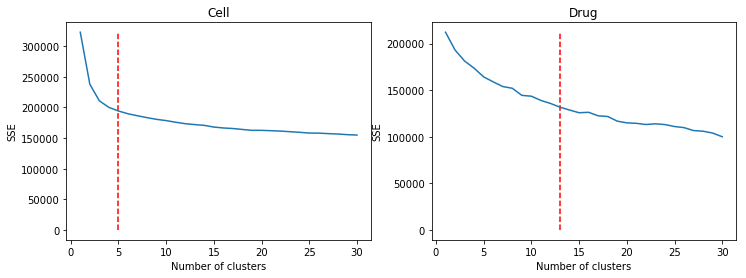

In [5]:
plot_kmeans(kmeans_cell, kmeans_drug, sse_cell, sse_drug, title='knn_total')

In [6]:
elbow_cell_true = len(np.unique(kmeans_cell.labels_))
elbow_drug_true = len(np.unique(kmeans_drug.labels_))

print('The optimal number of cell clusters using the elbow method is %1d' % elbow_cell_true)
print('The optimal number of drug clusters using the elbow method is %1d' % elbow_drug_true)

The optimal number of cell clusters using the elbow method is 5
The optimal number of drug clusters using the elbow method is 13


# Create graph representations

## Find optimal epsilon for cell and drug

In [7]:
cell_distance = create_distance(mx_center)
drug_distance = create_distance(mx_center.T)

## confirm distance matrices are symmetric
# np.allclose(cell_distance, cell_distance.T, rtol=1e-05, atol=1e-08)
# np.allclose(drug_distance, drug_distance.T, rtol=1e-05, atol=1e-08)

# np.where(cell_distance == 0, -np.inf, cell_distance)

# plt.hist(cell_distance[np.triu_indices(mx_center.shape[0], k = 1)]);
# plt.hist(drug_distance[np.triu_indices(mx_center.shape[1], k = 1)]);

C:\Users\jessb\anaconda3\envs\math_tools\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


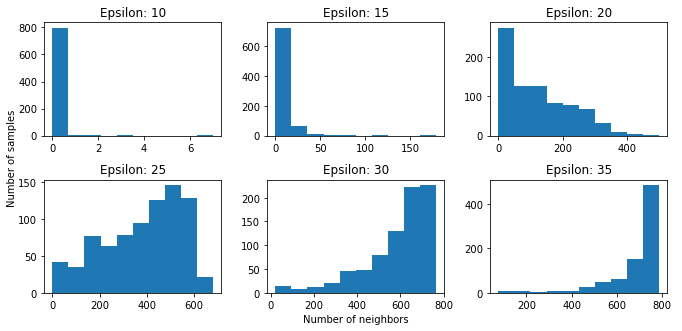

In [8]:
plot_epsilon(cell_distance, title='plots/epsilon_cell')

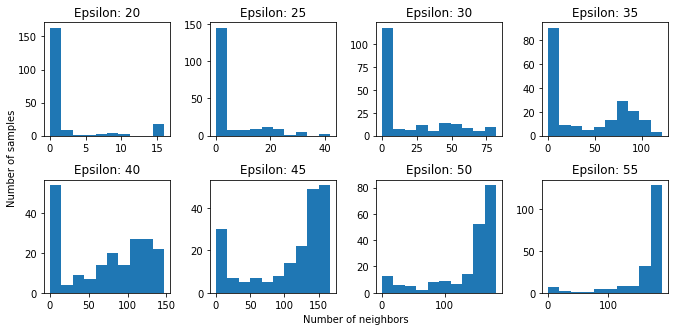

In [9]:
plot_epsilon(drug_distance, eps_start=20, eps_end=60, eps_step=5, n_cols=4,
             title='plots/epsilon_drug')

## Create adjacency matrices, annotated graphs

### Cell data

In [10]:
## manually change
elbow_cell = elbow_cell_true
elow_cell = 20
ehigh_cell = 30

In [11]:
col_names = ['Name', 'Name']
col_annots = ['TCGA Classification', 'Tissue']
annots = ['tcga', 'tissue']

In [12]:
## select k using elbow method
adj_knn_cell = create_adjacency(mx_center, knn=True, n=elbow_cell)
G_knn_cell = return_graph(adj_knn_cell, list_cell, df_cell_info, col_names, col_annots, annots)
# nx.get_node_attributes(G_knn_cell, 'tissue').values()

In [13]:
## select epsilon after manual inspection
adj_elow_cell = create_adjacency(mx_center, knn=False, epsilon=elow_cell)
G_elow_cell = return_graph(adj_elow_cell, list_cell, df_cell_info, col_names, col_annots, annots)

adj_ehigh_cell = create_adjacency(mx_center, knn=False, epsilon=ehigh_cell)
G_ehigh_cell = return_graph(adj_ehigh_cell, list_cell, df_cell_info, col_names, col_annots, annots)

In [14]:
annot = 'tissue'

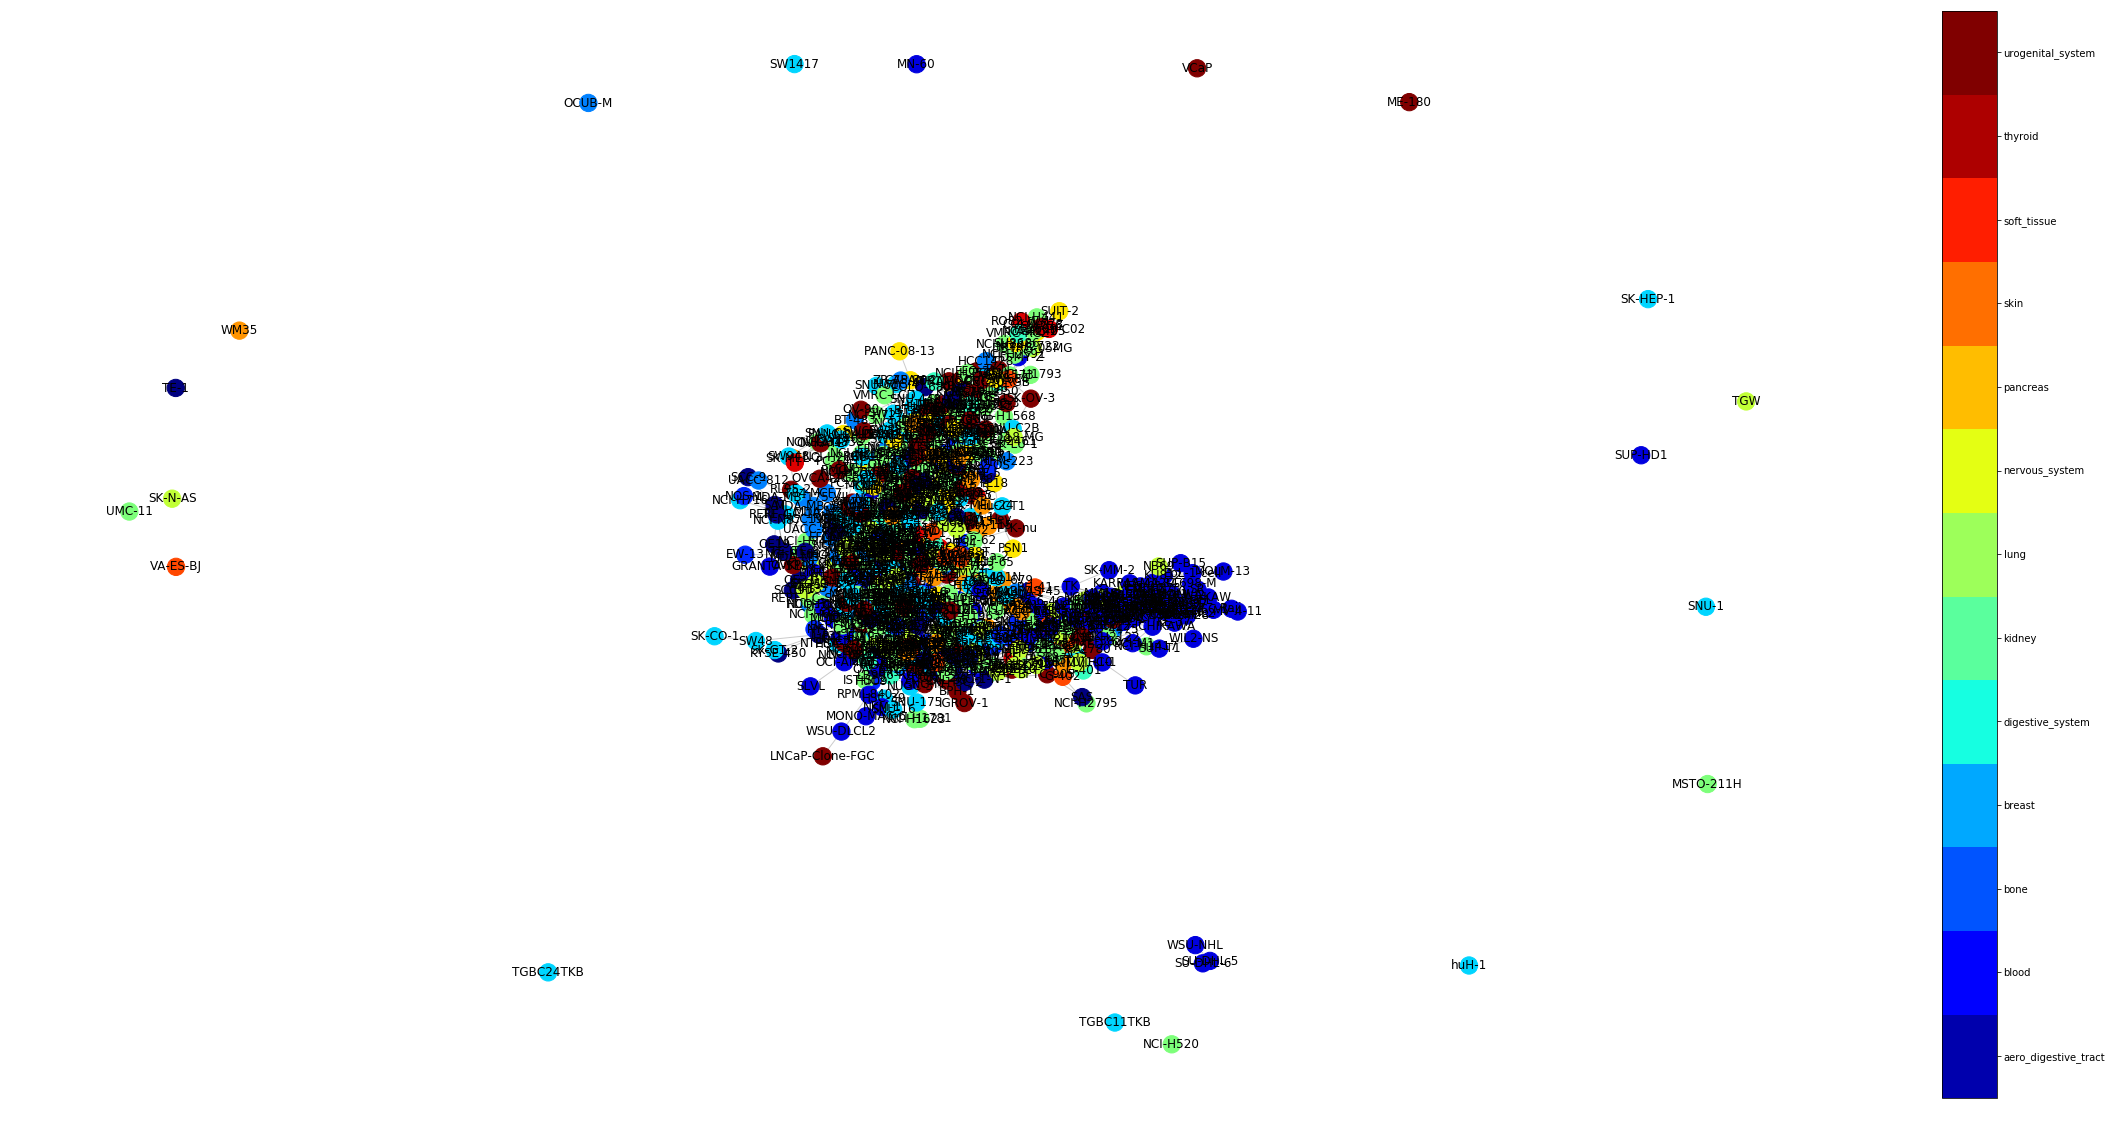

In [15]:
plot_graph(G_knn_cell, annot, title='plots/graph_knn_cell')

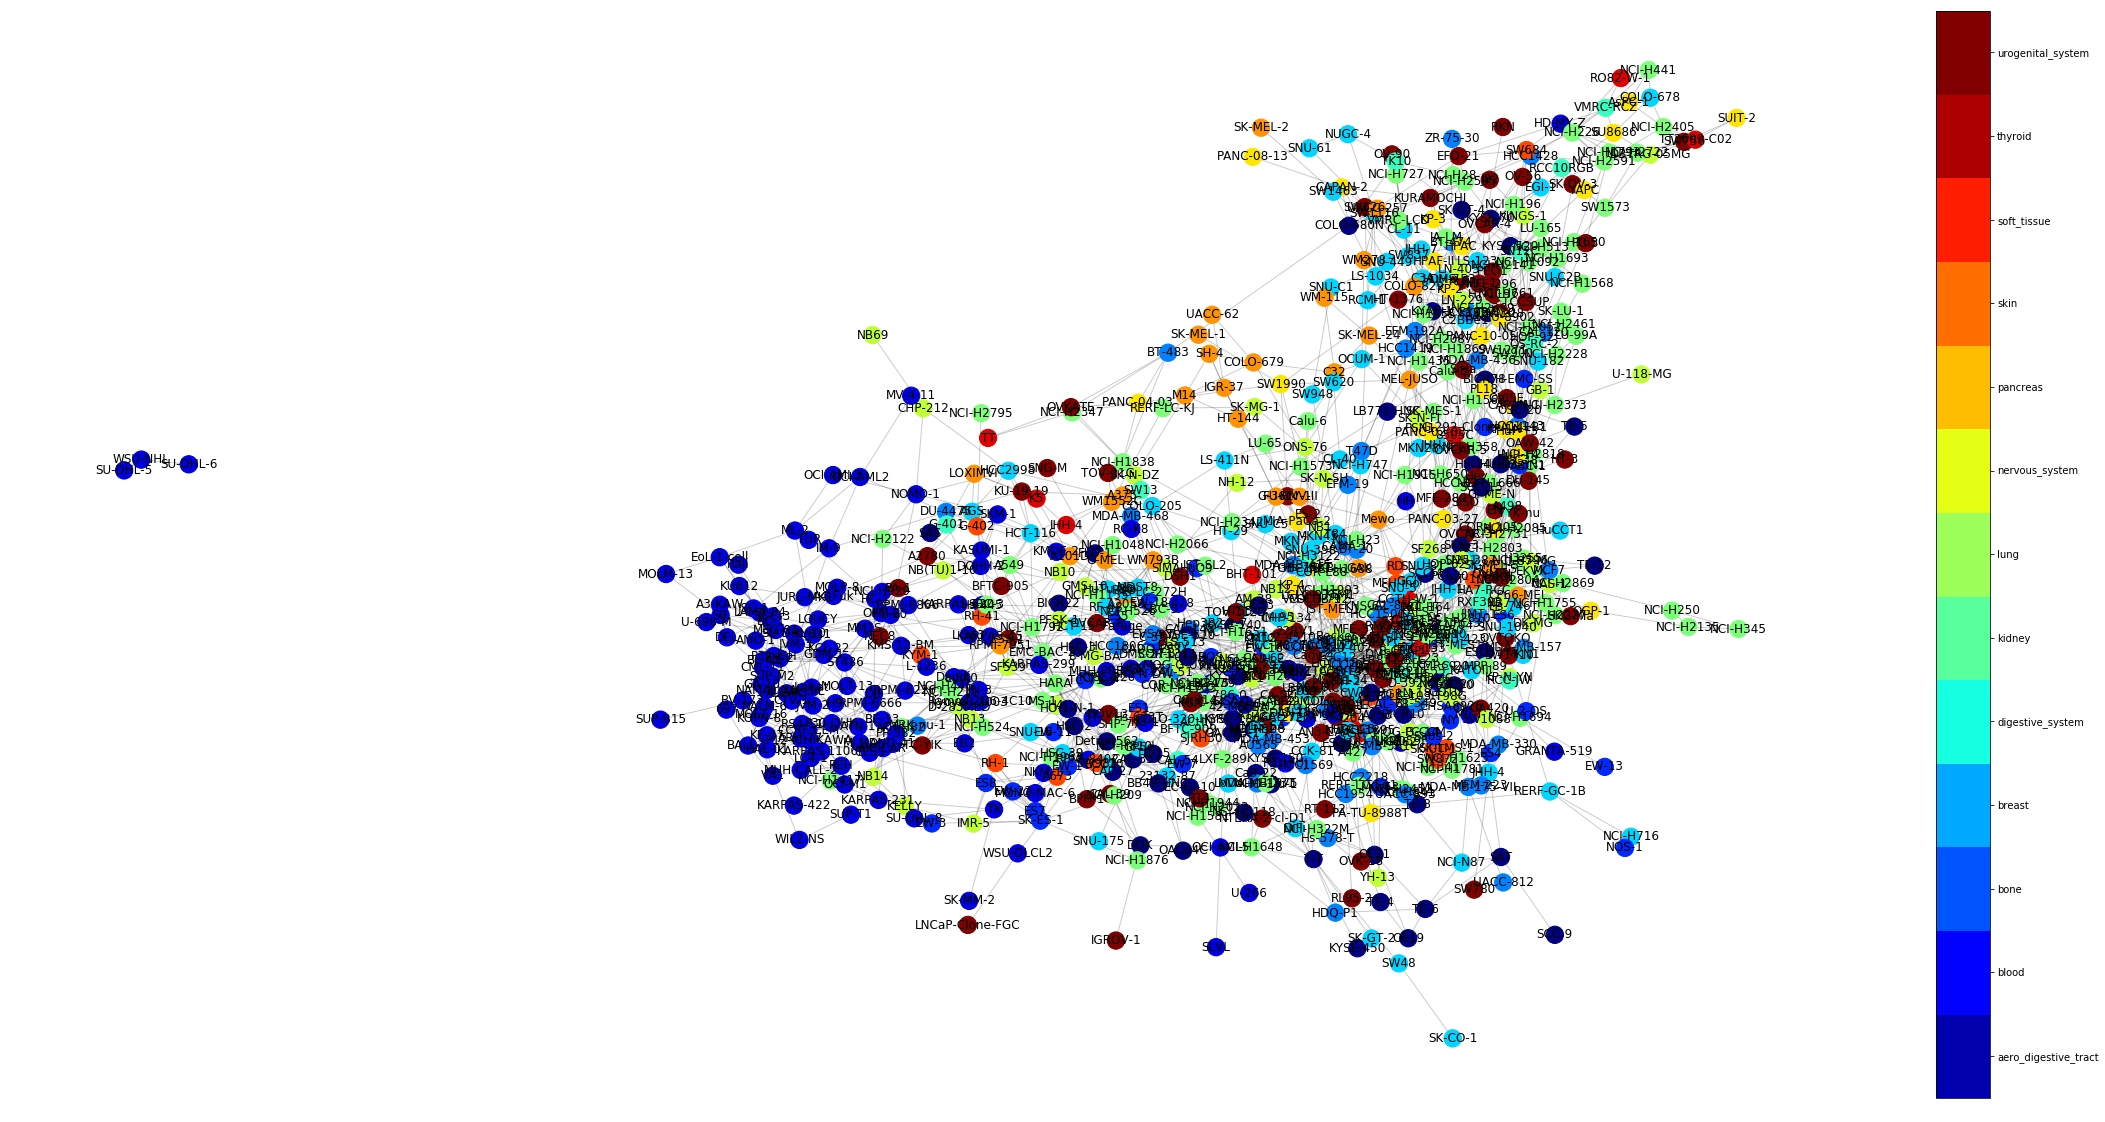

In [16]:
plot_graph(G_knn_cell, annot, remove=True, title='plots/graph_knn_cell_remove')

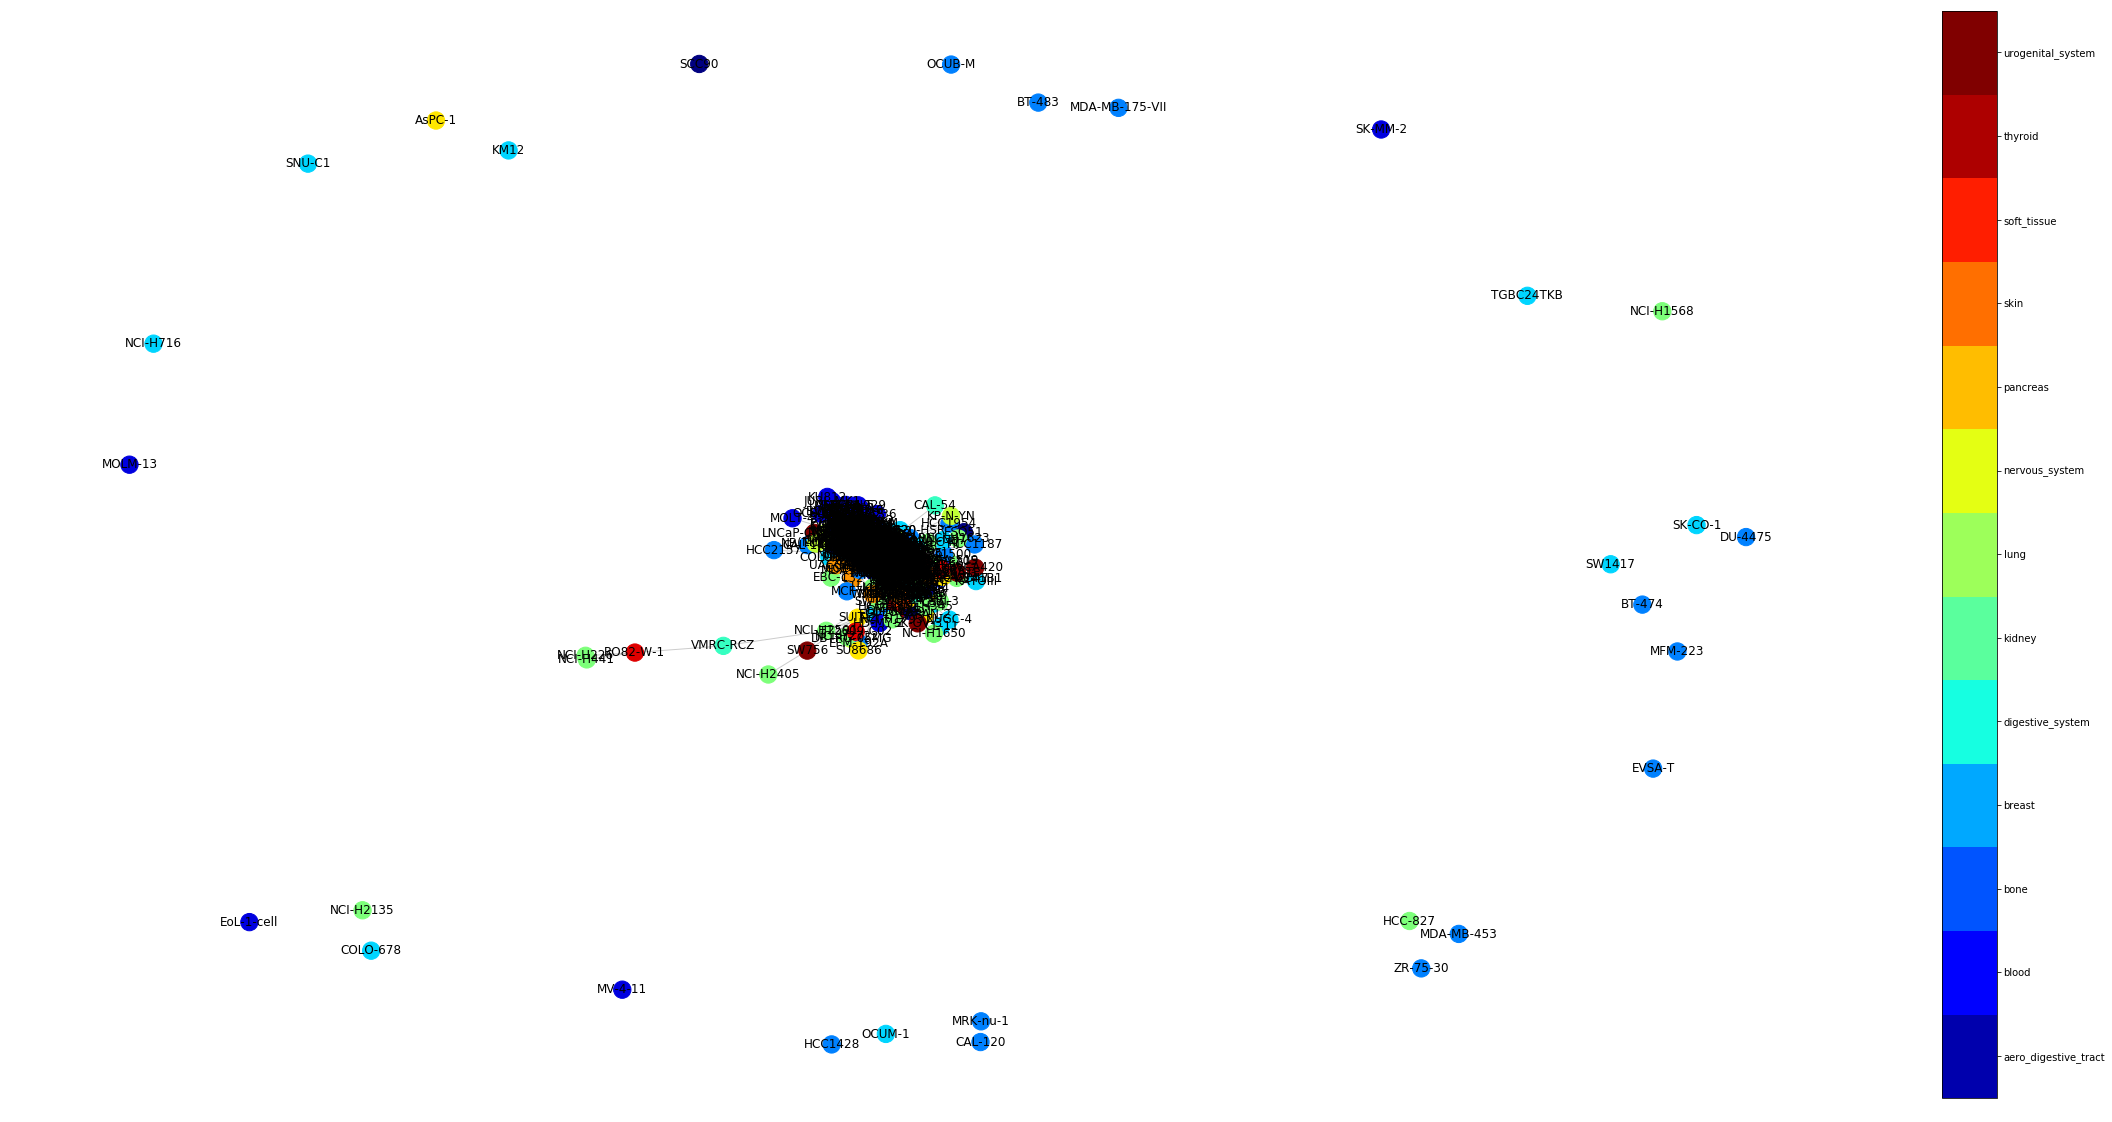

In [17]:
plot_graph(G_elow_cell, annot, title='plots/graph_elow_cell')

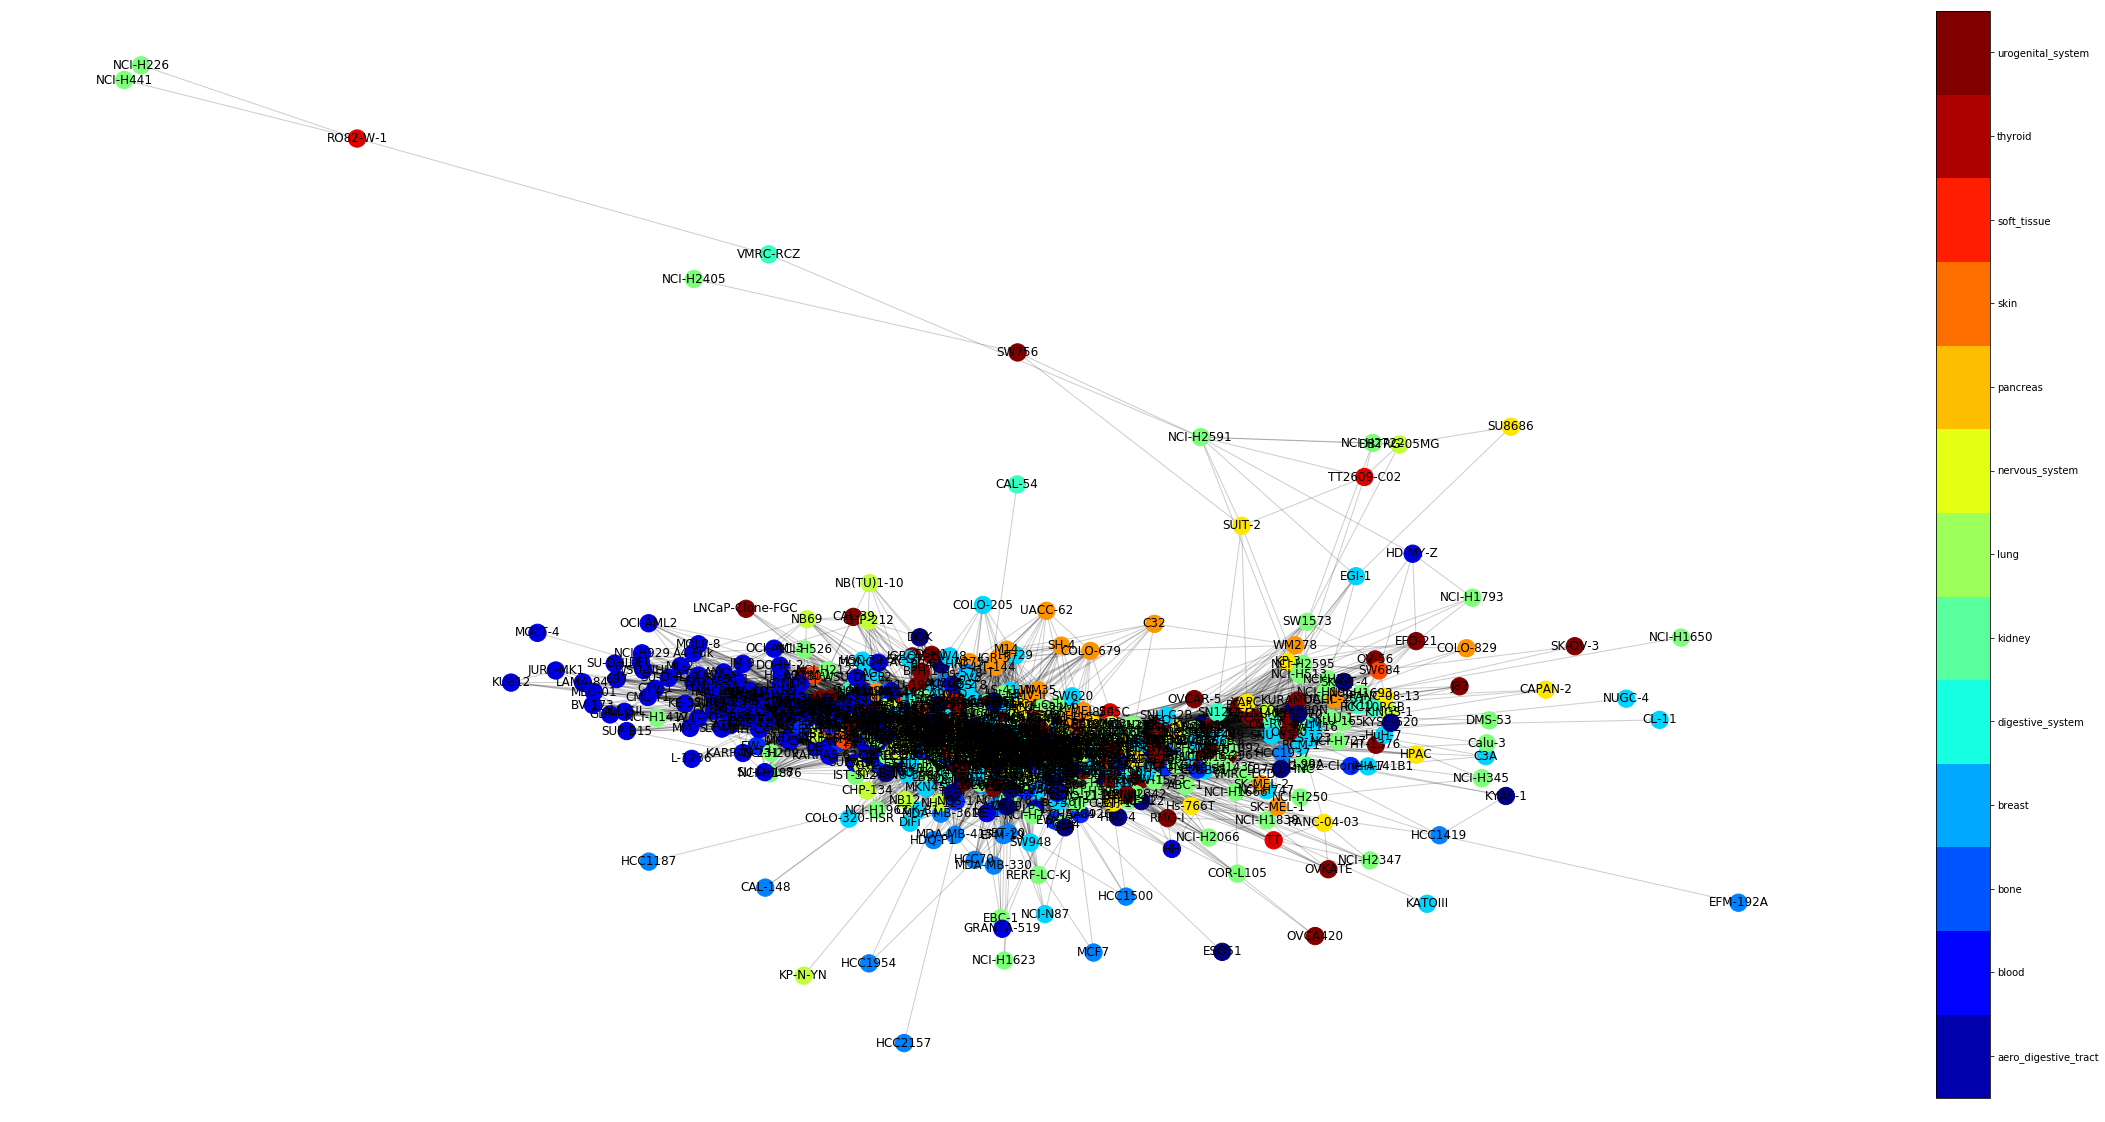

In [18]:
plot_graph(G_elow_cell, annot, remove=True, title='plots/graph_elow_cell_remove')

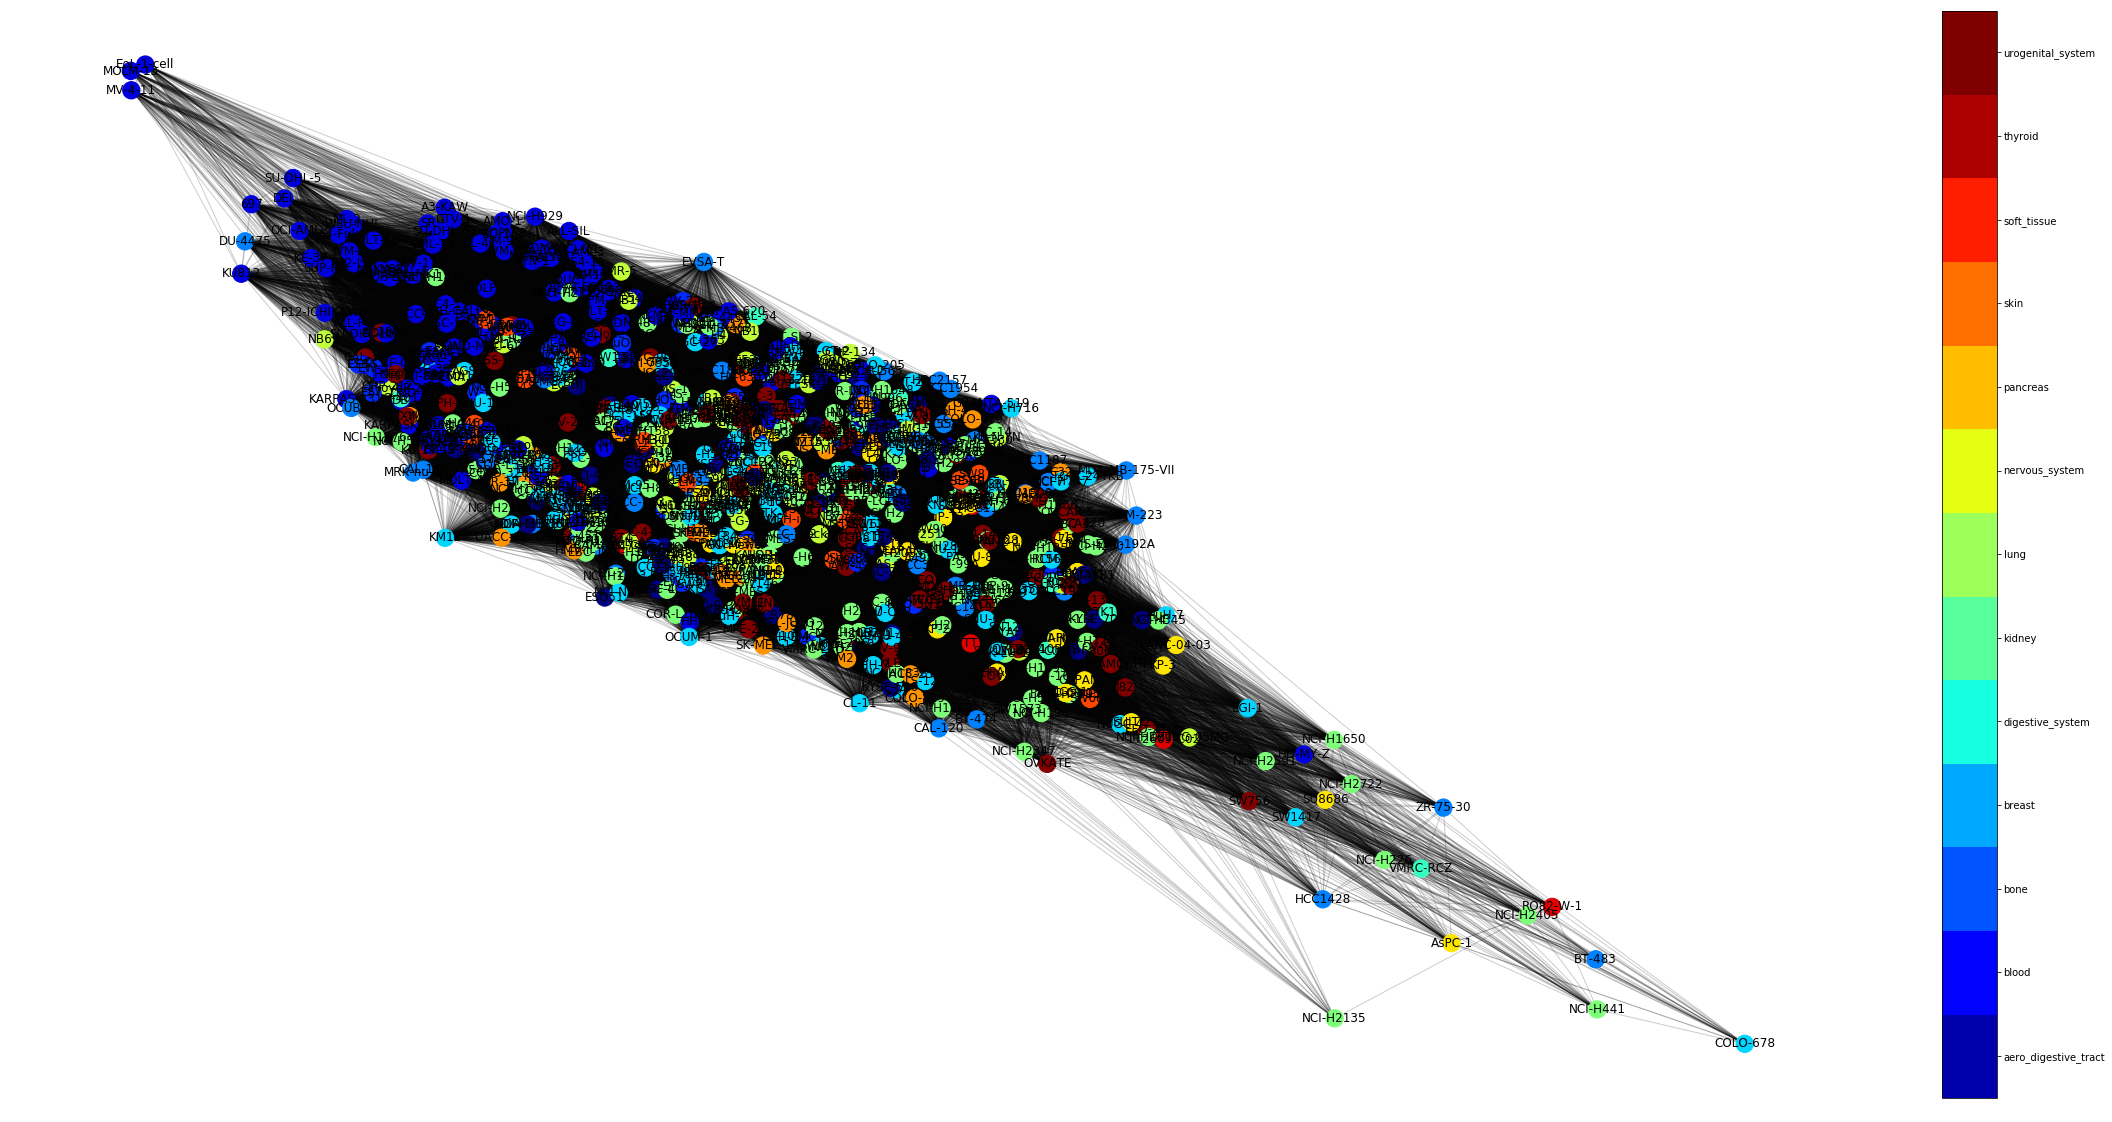

In [19]:
plot_graph(G_ehigh_cell, annot, title='plots/graph_ehigh_cell')

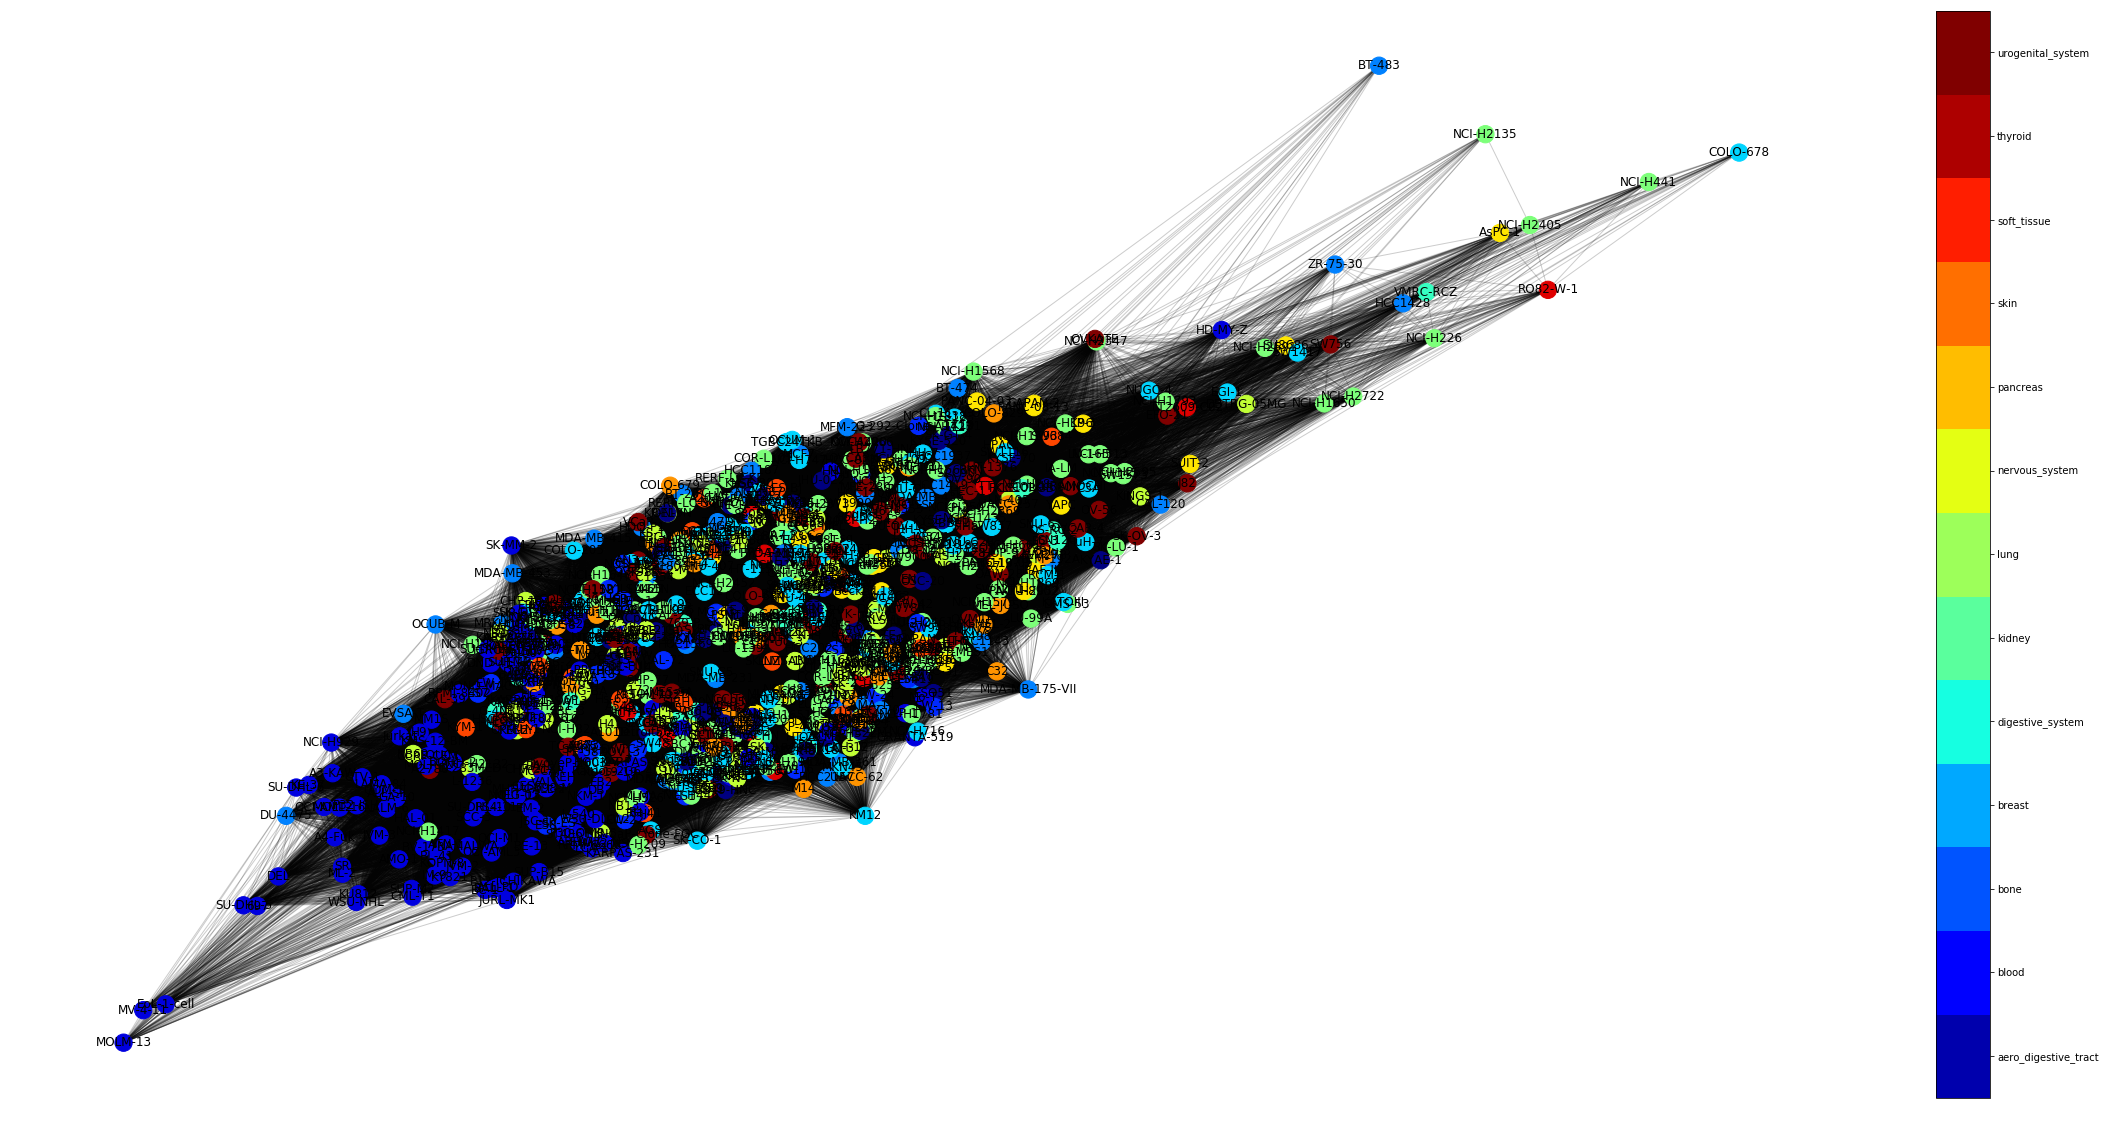

In [20]:
plot_graph(G_ehigh_cell, annot, remove=True, title='plots/graph_ehigh_cell_remove')

### Drug data

In [21]:
## manually change
elbow_drug = elbow_drug_true
elow_drug = 45
ehigh_drug = 50

In [22]:
col_names = ['drug_unique', 'drug_unique']
col_annots = ['pathway_name', 'pathway_short']
annots = ['path', 'path_short']

In [23]:
## select k using elbow method
adj_knn_drug = create_adjacency(mx_center.T, knn=True, n=elbow_drug)
G_knn_drug = return_graph(adj_knn_drug, list_drug, df_drug_info, col_names, col_annots, annots)
# nx.get_node_attributes(G_knn_drug, 'path_short').values()

In [24]:
## select epsilon after manual inspection
adj_elow_drug = create_adjacency(mx_center.T, knn=False, epsilon=45)
G_elow_drug = return_graph(adj_elow_drug, list_drug, df_drug_info, col_names, col_annots, annots)

adj_ehigh_drug = create_adjacency(mx_center.T, knn=False, epsilon=50)
G_ehigh_drug = return_graph(adj_ehigh_drug, list_drug, df_drug_info, col_names, col_annots, annots)

In [25]:
annot = 'path_short'

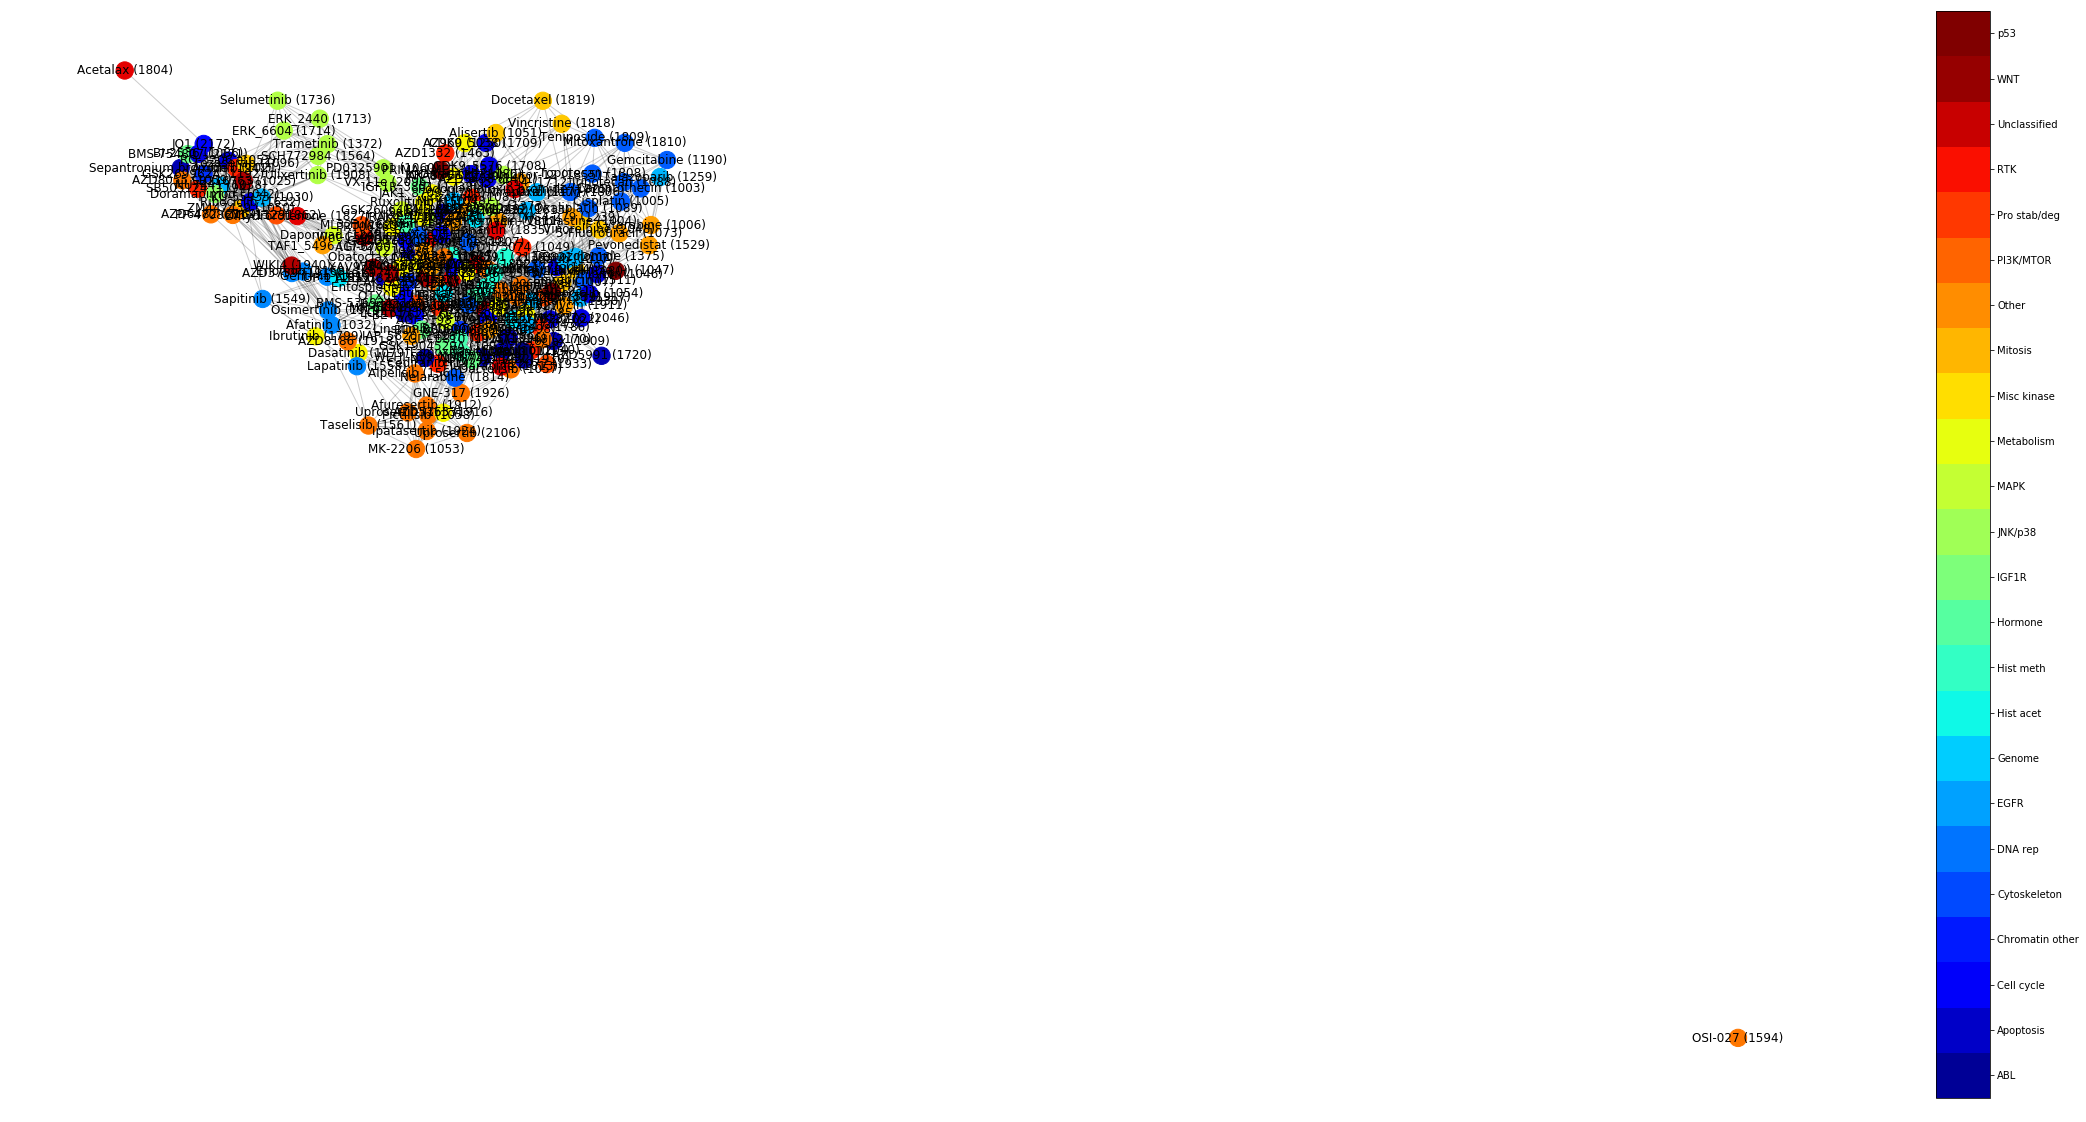

In [26]:
plot_graph(G_knn_drug, annot, title='plots/graph_knn_drug')

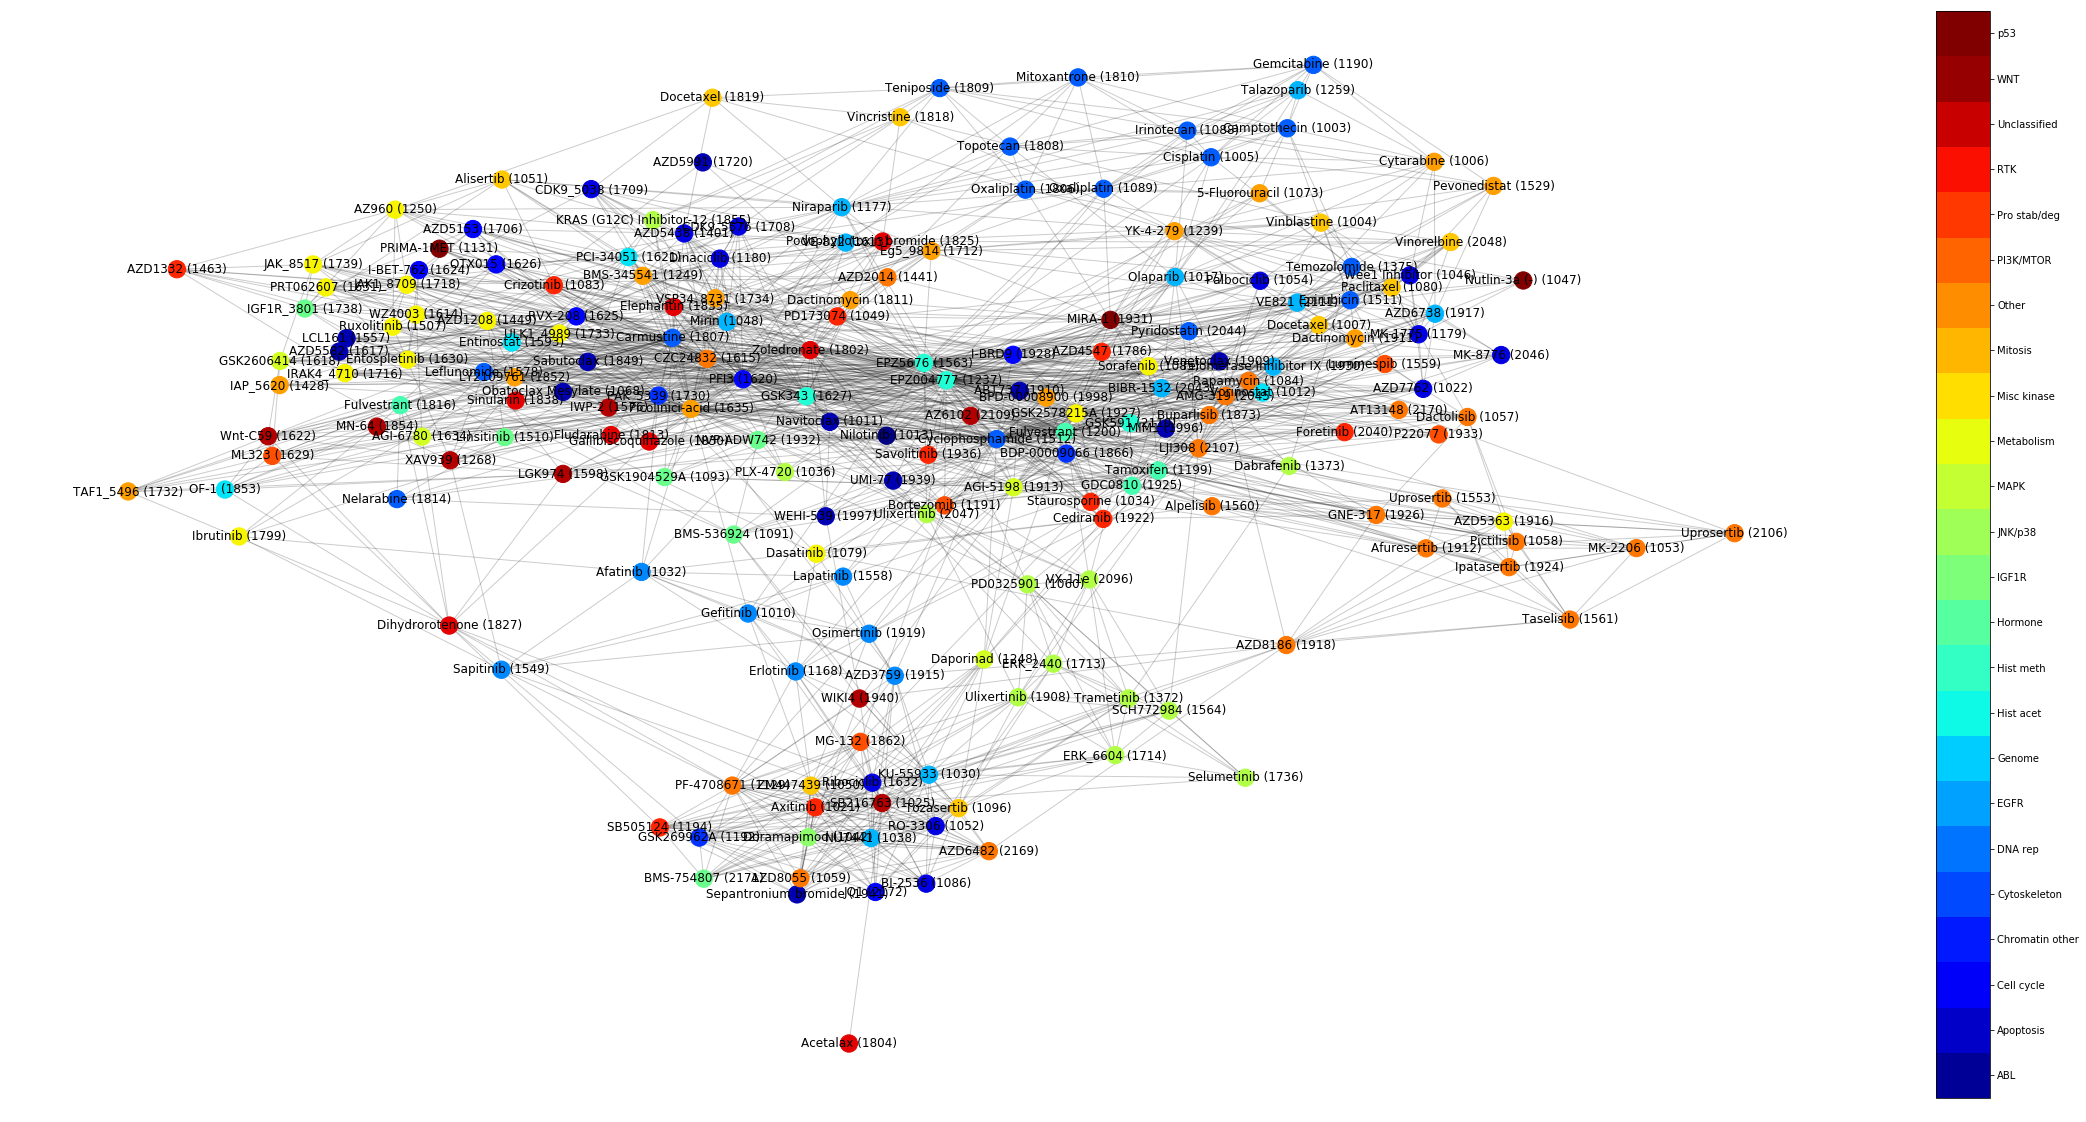

In [27]:
plot_graph(G_knn_drug, annot, remove=True, title='plots/graph_knn_drug_remove')

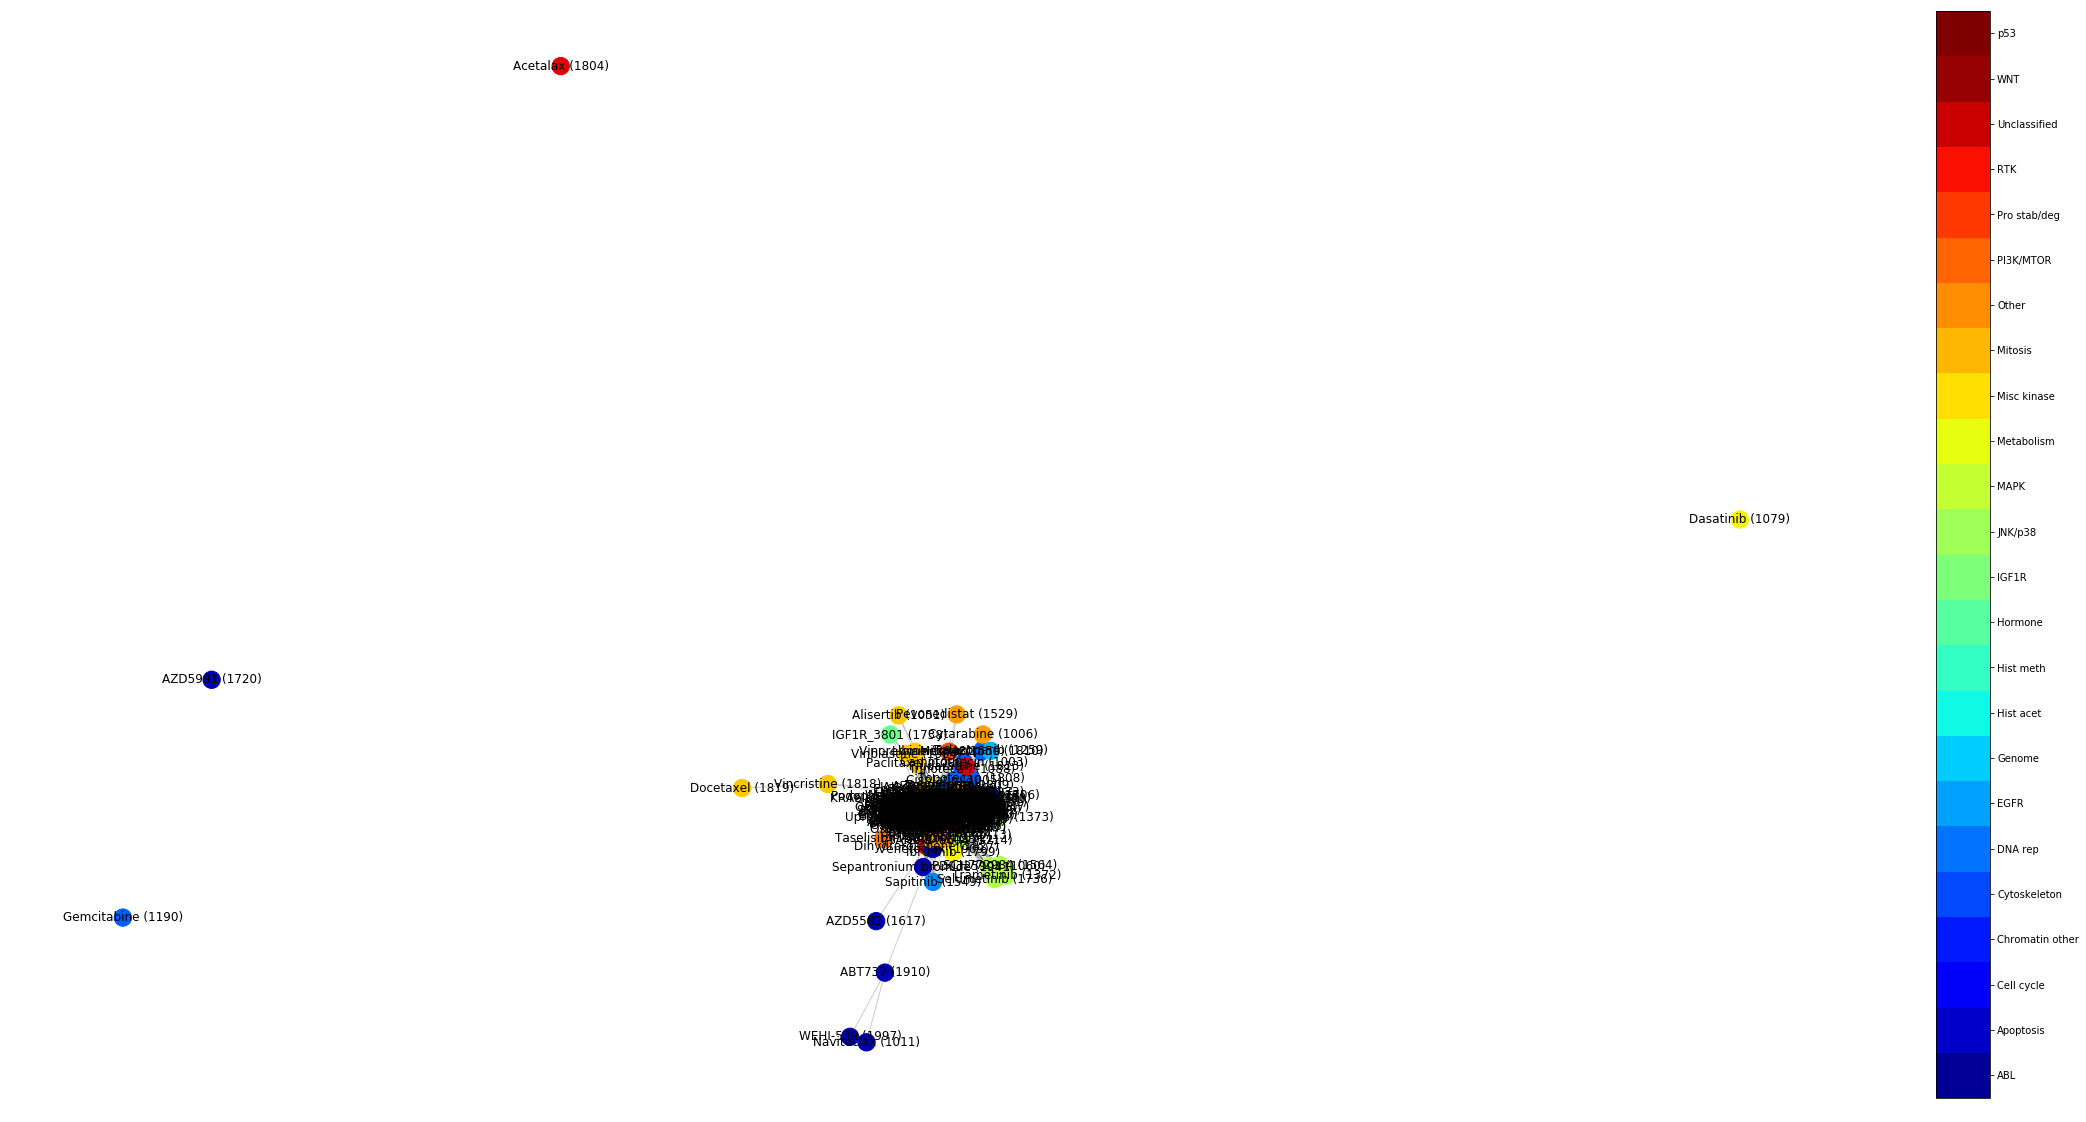

In [28]:
plot_graph(G_elow_drug, annot, title='plots/graph_elow_drug')

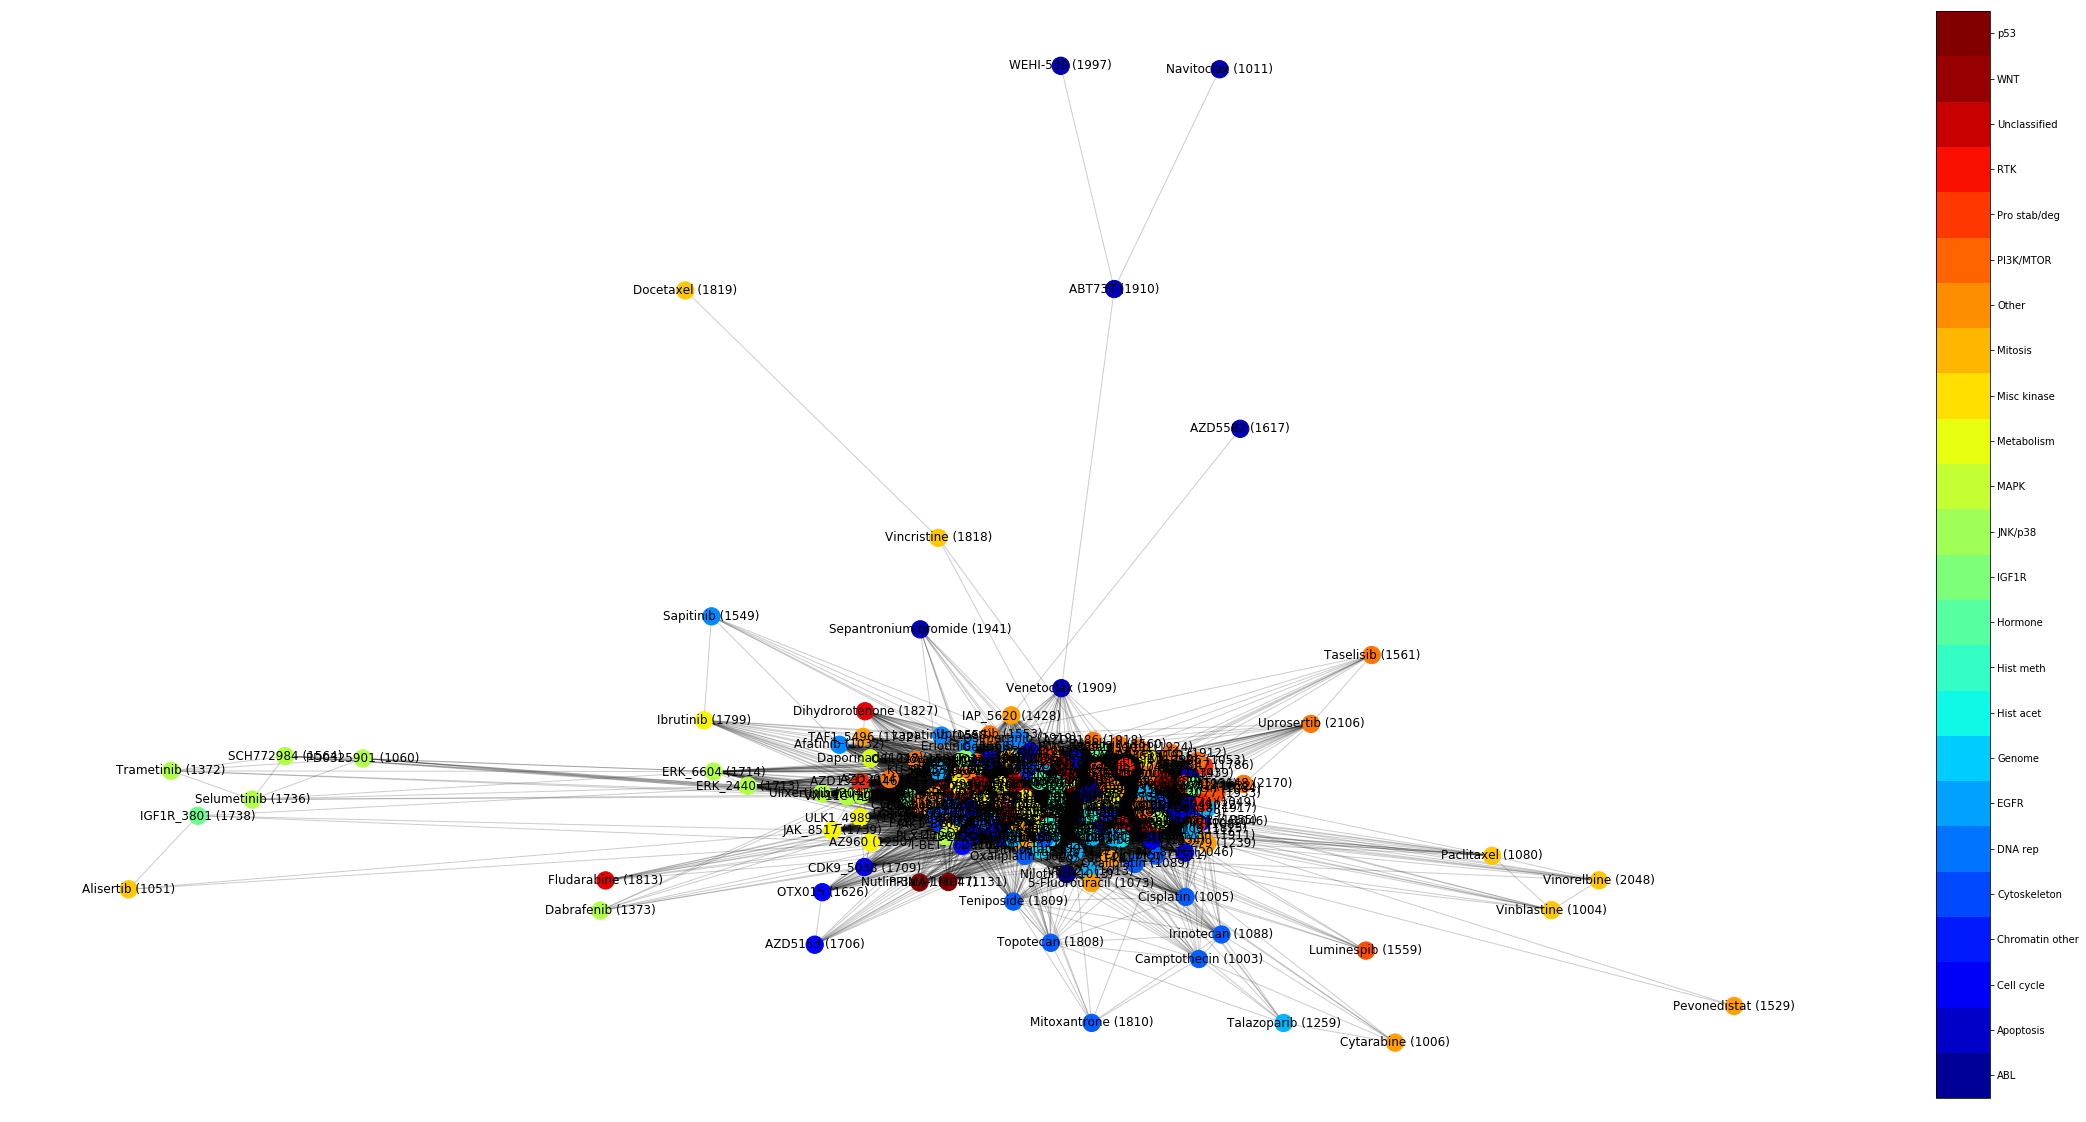

In [29]:
plot_graph(G_elow_drug, annot, remove=True, title='plots/graph_elow_drug_remove')

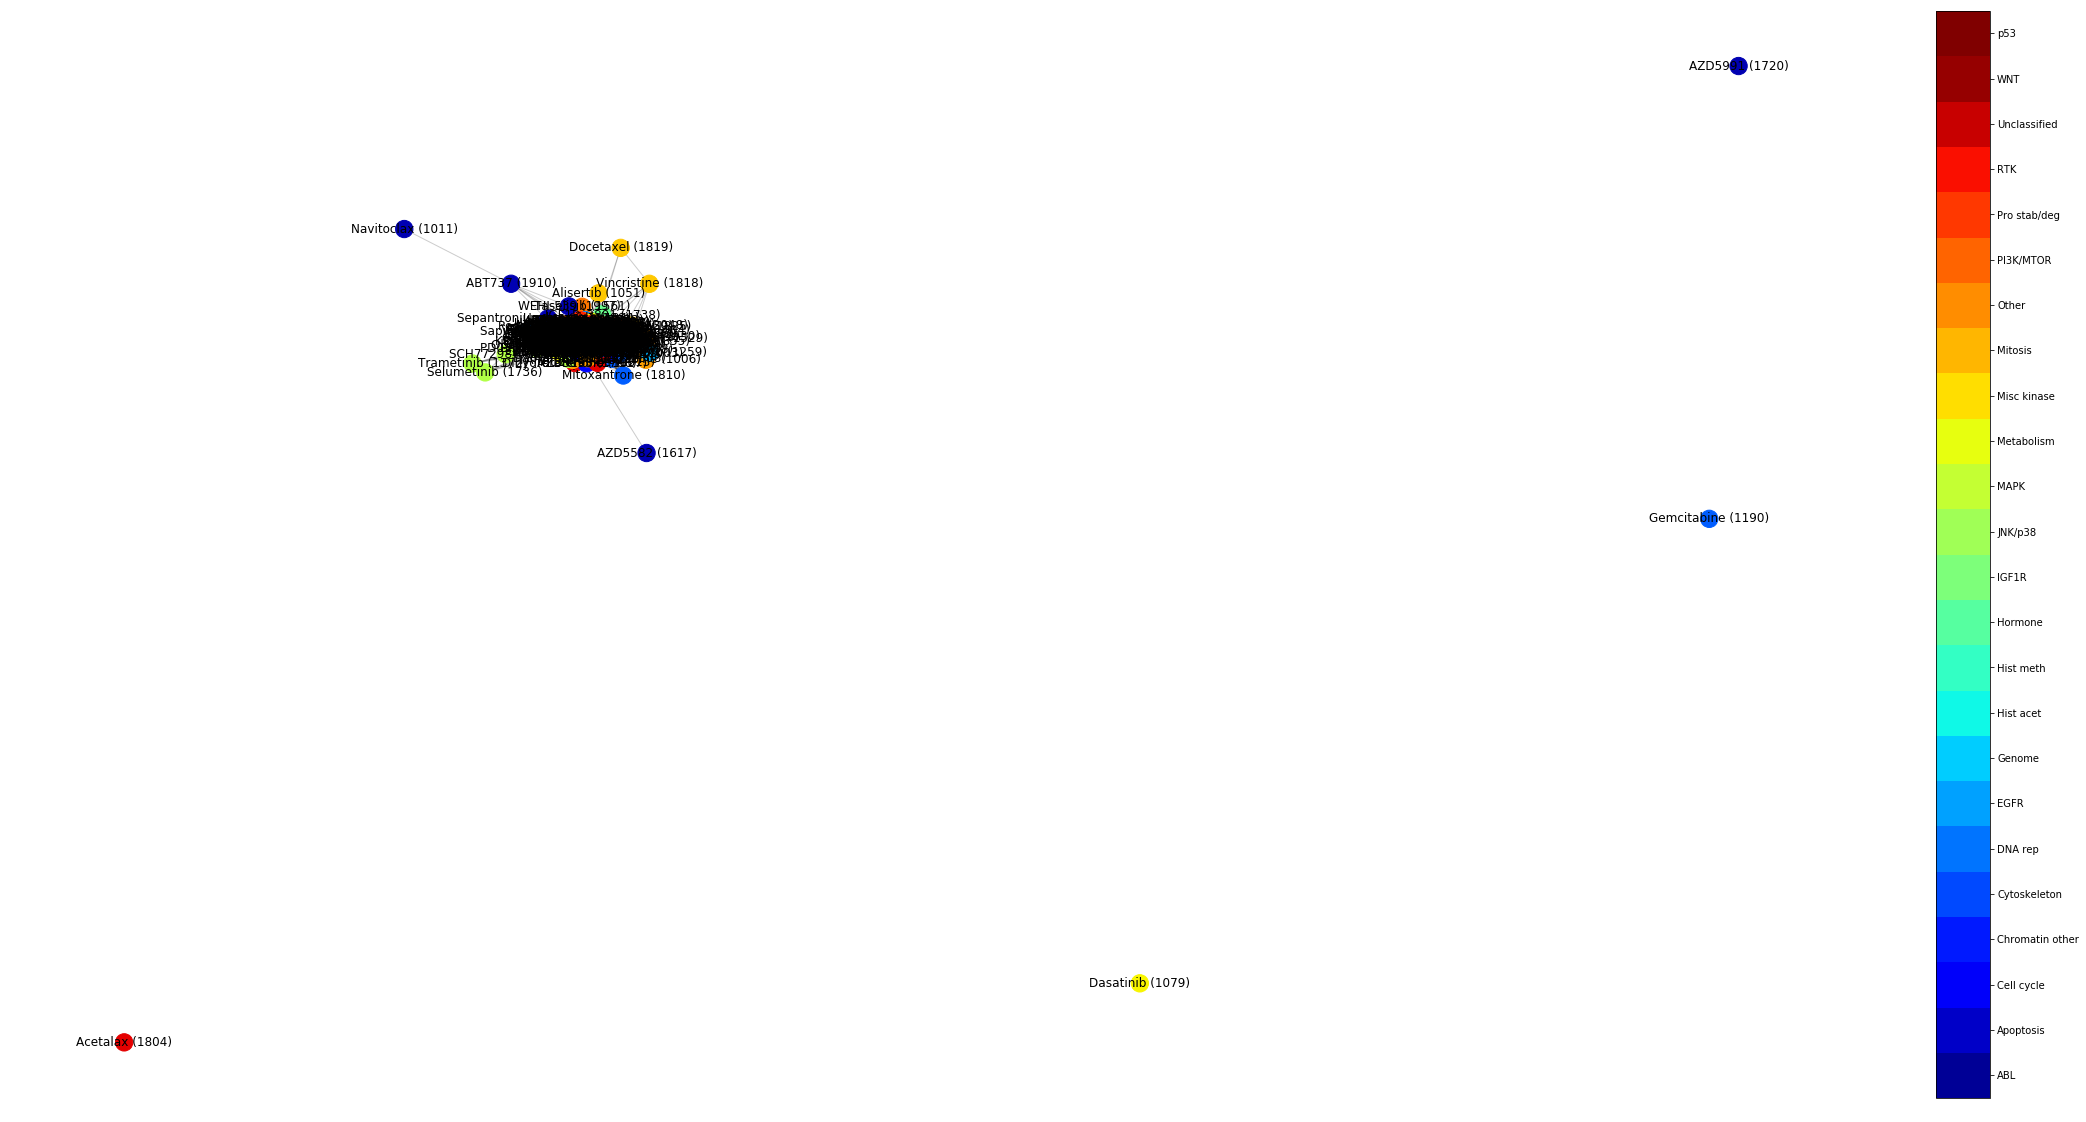

In [30]:
plot_graph(G_ehigh_drug, annot, title='plots/graph_ehigh_drug')

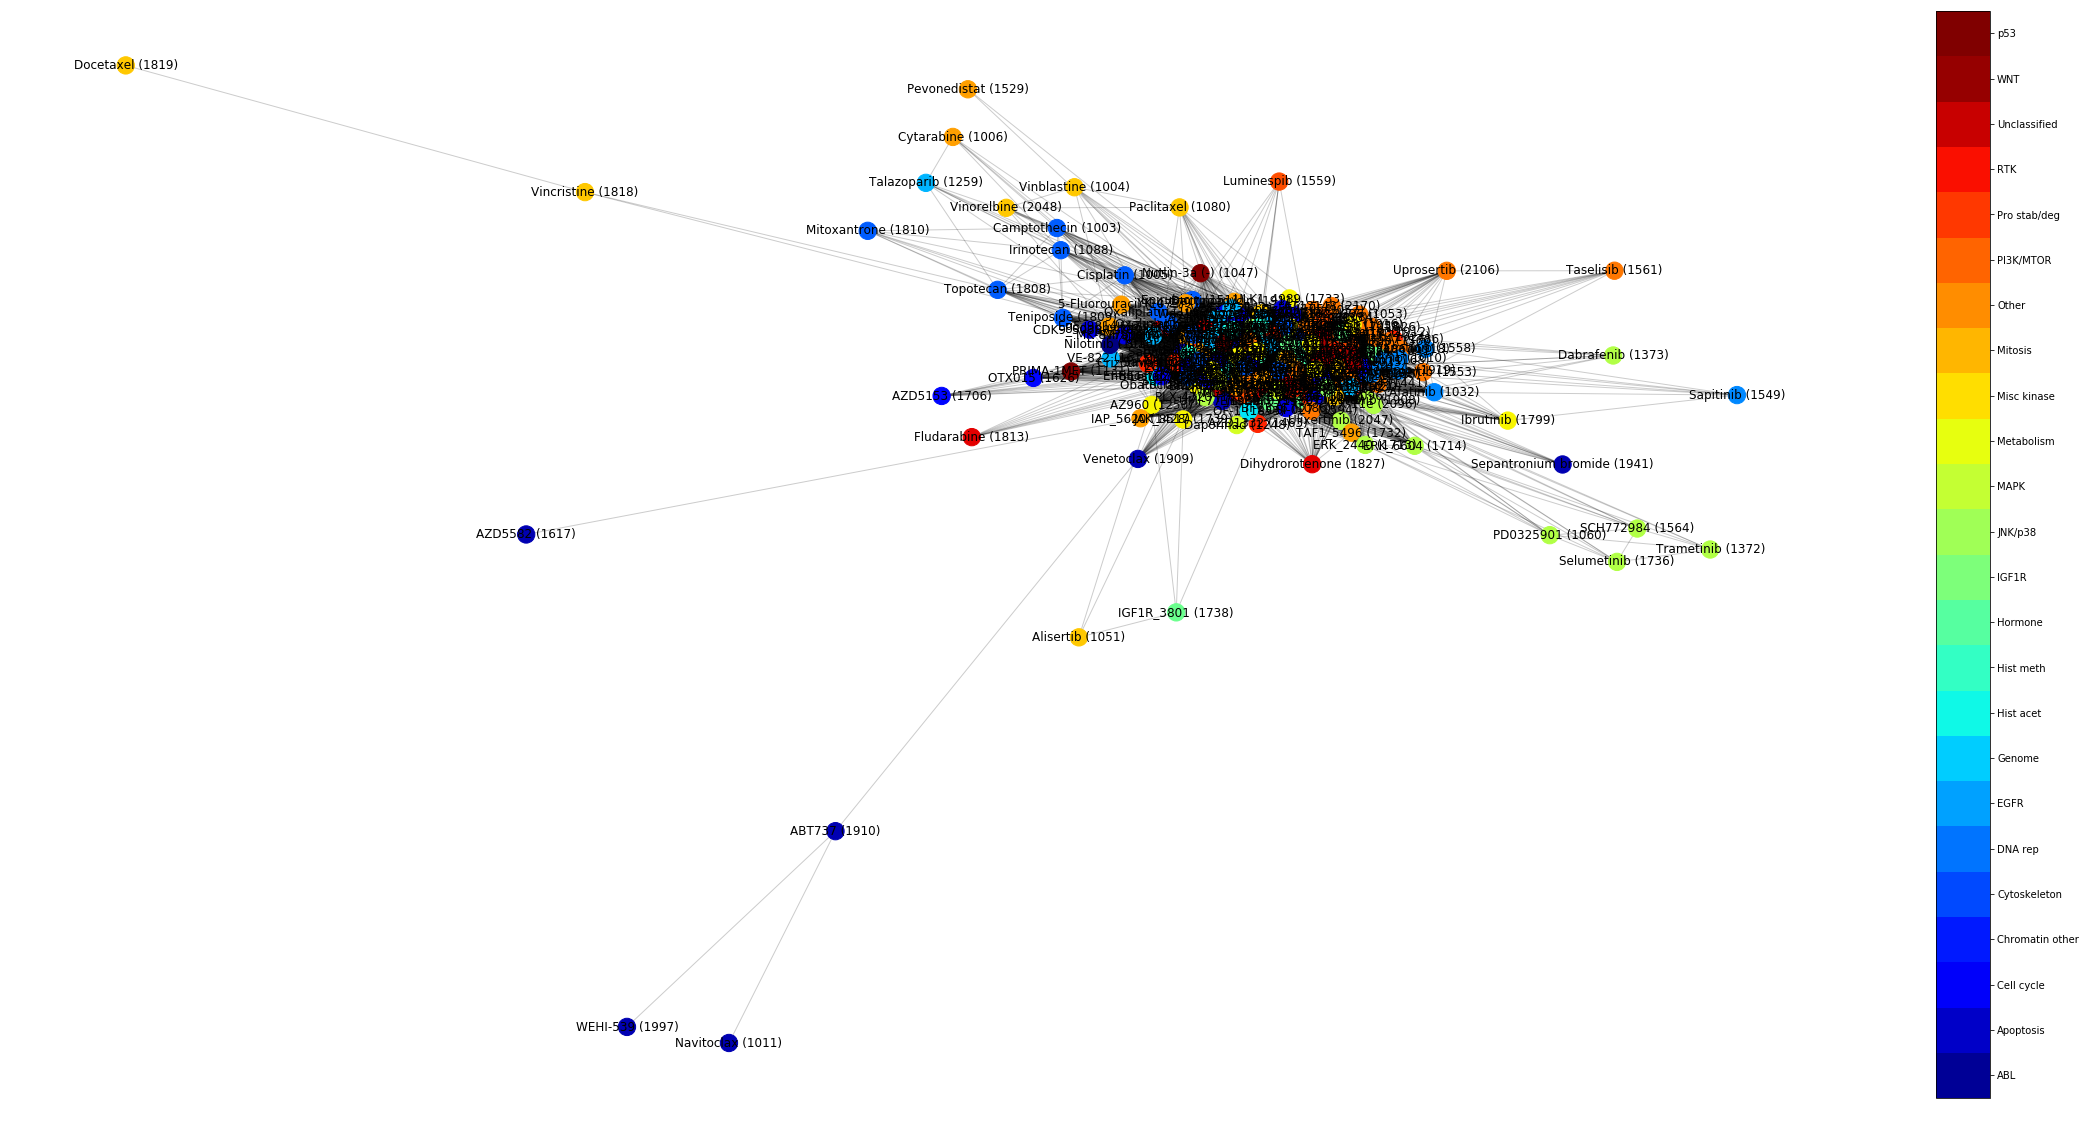

In [31]:
plot_graph(G_elow_drug, annot, remove=True, title='plots/graph_elow_drug_remove')

# Create Laplacian and find eigenvalues/vectors

## For cell lines

In [32]:
laplacian_knn_cell = create_laplacian(adj_knn_cell)
laplacian_elow_cell = create_laplacian(adj_elow_cell)
laplacian_ehigh_cell = create_laplacian(adj_ehigh_cell)

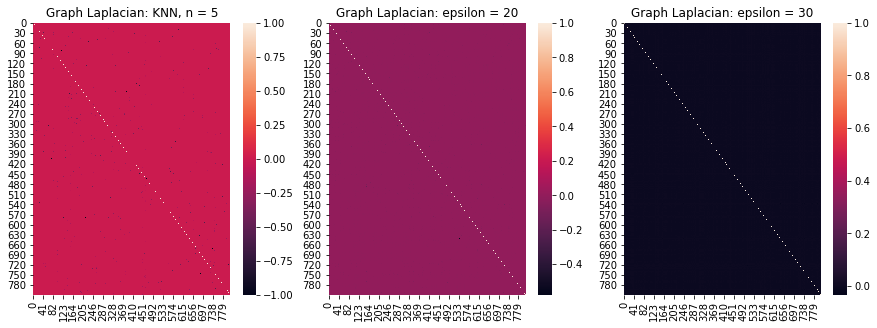

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(laplacian_knn_cell, ax=ax[0]);
ax[0].set_title('Graph Laplacian: KNN, n = ' + str(elbow_cell));
sns.heatmap(laplacian_elow_cell, ax=ax[1]);
ax[1].set_title(f'Graph Laplacian: epsilon = {elow_cell}');
sns.heatmap(laplacian_ehigh_cell, ax=ax[2]);
ax[2].set_title(f'Graph Laplacian: epsilon = {ehigh_cell}');
plt.savefig('plots/laplacian_cells.png',bbox_inches='tight');

In [34]:
eigenvals_knn_cell, eigenvcts_knn_cell = compute_spectrum(laplacian_knn_cell)
eigenvals_elow_cell, eigenvcts_elow_cell = compute_spectrum(laplacian_elow_cell)
eigenvals_ehigh_cell, eigenvcts_ehigh_cell = compute_spectrum(laplacian_ehigh_cell)

In [35]:
n_knn_cell = len(np.argwhere(abs(eigenvals_knn_cell) < 1e-5))
n_elow_cell = len(np.argwhere(abs(eigenvals_elow_cell) < 1e-5))
n_ehigh_cell = len(np.argwhere(abs(eigenvals_ehigh_cell) < 1e-5))

In [36]:
n_cell = [n_knn_cell, n_elow_cell, n_ehigh_cell]
eigenvals_cell = [eigenvals_knn_cell, eigenvals_elow_cell, eigenvals_ehigh_cell]
name_cell = ['KNN, N = ' + str(elbow_cell), 'Epsilon: ' + str(elow_cell), 'Epsilon: ' + str(ehigh_cell)]

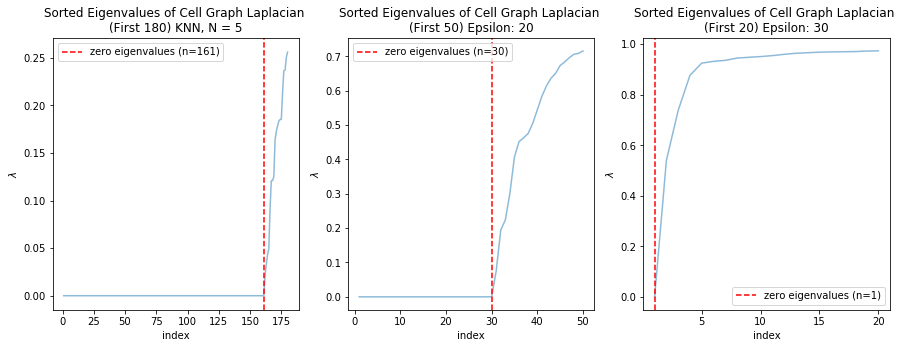

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, eigenvals in enumerate(eigenvals_cell):
    n = n_cell[i]
    name = name_cell[i]
    index_lim = round(n + 20, -1)
    sns.scatterplot(x=range(1, eigenvals[: index_lim].size + 1), y=eigenvals[: index_lim], s=80, ax=ax[i])
    sns.lineplot(x=range(1, eigenvals[: index_lim].size + 1), y=eigenvals[: index_lim], alpha=0.5, ax=ax[i])
    ax[i].axvline(x=n, color='red', label=f'zero eigenvalues (n={n})', linestyle='--');
    ax[i].legend();
    ax[i].set(title=f'Sorted Eigenvalues of Cell Graph Laplacian \n(First {index_lim}) {name}', 
              xlabel='index', ylabel=r'$\lambda$');
    
plt.savefig('plots/eigenvectors_cells.png',bbox_inches='tight');

In [38]:
proj_knn_cell = eigenvcts_knn_cell[:, :n_knn_cell]
proj_elow_cell = eigenvcts_elow_cell[:, :n_elow_cell]
proj_ehigh_cell = eigenvcts_ehigh_cell[:, :n_ehigh_cell]

proj_cell = [proj_knn_cell, proj_elow_cell, proj_ehigh_cell]

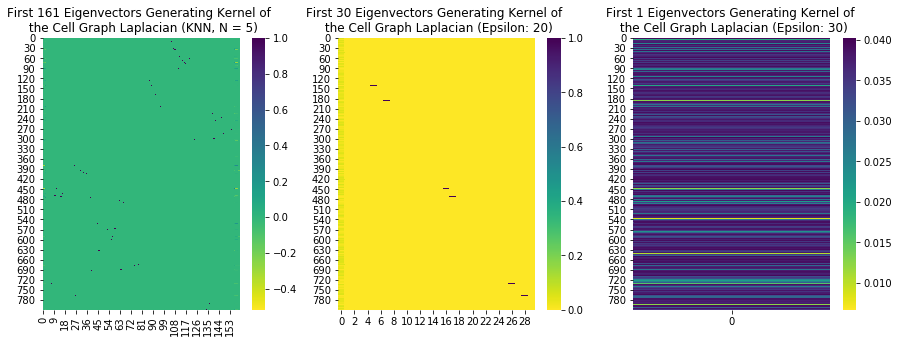

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, projection in enumerate(proj_cell):
    n = n_cell[i]
    name = name_cell[i]
    sns.heatmap(projection, ax=ax[i], cmap='viridis_r')
    ax[i].set(title=f'First {n} Eigenvectors Generating Kernel of \n the Cell Graph Laplacian ({name})');
    
plt.savefig('plots/kernel_cells.png',bbox_inches='tight');

## For drugs

In [40]:
laplacian_knn_drug = create_laplacian(adj_knn_drug)
laplacian_elow_drug = create_laplacian(adj_elow_drug)
laplacian_ehigh_drug = create_laplacian(adj_ehigh_drug)

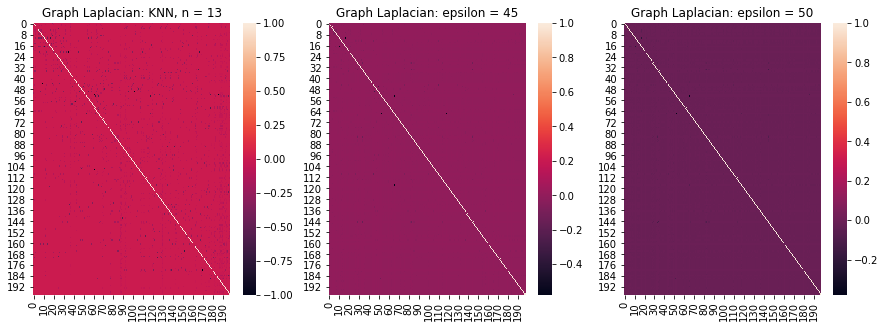

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(laplacian_knn_drug, ax=ax[0]);
ax[0].set_title('Graph Laplacian: KNN, n = ' + str(elbow_drug));
sns.heatmap(laplacian_elow_drug, ax=ax[1]);
ax[1].set_title('Graph Laplacian: epsilon = 45');
sns.heatmap(laplacian_ehigh_drug, ax=ax[2]);
ax[2].set_title('Graph Laplacian: epsilon = 50');
plt.savefig('plots/laplacian_drugs.png',bbox_inches='tight');

In [42]:
eigenvals_knn_drug, eigenvcts_knn_drug = compute_spectrum(laplacian_knn_drug)
eigenvals_elow_drug, eigenvcts_elow_drug = compute_spectrum(laplacian_elow_drug)
eigenvals_ehigh_drug, eigenvcts_ehigh_drug = compute_spectrum(laplacian_ehigh_drug)

In [43]:
n_knn_drug = len(np.argwhere(abs(eigenvals_knn_drug) < 1e-5))
n_elow_drug = len(np.argwhere(abs(eigenvals_elow_drug) < 1e-5))
n_ehigh_drug = len(np.argwhere(abs(eigenvals_ehigh_drug) < 1e-5))

In [44]:
n_knn_drug = len(np.argwhere(abs(eigenvals_knn_drug) < 1e-5))
n_elow_drug = len(np.argwhere(abs(eigenvals_elow_drug) < 1e-5))
n_ehigh_drug = len(np.argwhere(abs(eigenvals_ehigh_drug) < 1e-5))

In [45]:
n_drug = [n_knn_cell, n_elow_drug, n_ehigh_drug]
eigenvals_drug = [eigenvals_knn_cell, eigenvals_elow_drug, eigenvals_ehigh_drug]
name_drug = ['KNN, N = ' + str(elbow_drug), 'Epsilon: 45', 'Epsilon: 50']

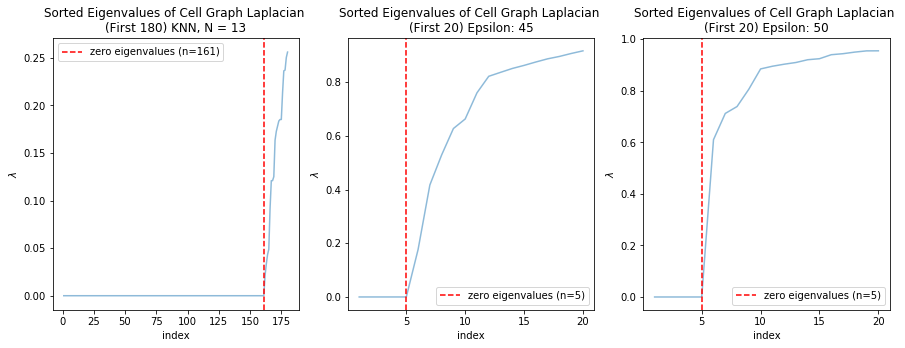

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, eigenvals in enumerate(eigenvals_drug):
    n = n_drug[i]
    name = name_drug[i]
    index_lim = round(n + 20, -1)
    sns.scatterplot(x=range(1, eigenvals[: index_lim].size + 1), y=eigenvals[: index_lim], s=80, ax=ax[i])
    sns.lineplot(x=range(1, eigenvals[: index_lim].size + 1), y=eigenvals[: index_lim], alpha=0.5, ax=ax[i])
    ax[i].axvline(x=n, color='red', label=f'zero eigenvalues (n={n})', linestyle='--');
    ax[i].legend();
    ax[i].set(title=f'Sorted Eigenvalues of Cell Graph Laplacian \n(First {index_lim}) {name}', 
              xlabel='index', ylabel=r'$\lambda$');

plt.savefig('plots/eigenvectors_drugs.png',bbox_inches='tight');

In [47]:
proj_knn_drug = eigenvcts_knn_drug[:, :n_knn_drug]
proj_elow_drug = eigenvcts_elow_drug[:, :n_elow_drug]
proj_ehigh_drug = eigenvcts_ehigh_drug[:, :n_ehigh_drug]

proj_drug = [proj_knn_drug, proj_elow_drug, proj_ehigh_drug]

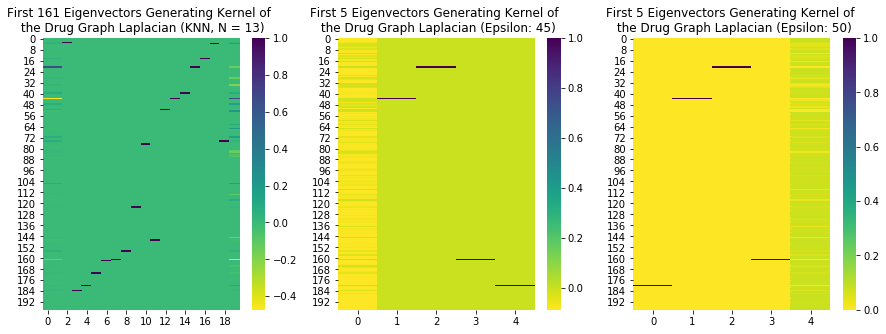

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, projection in enumerate(proj_drug):
    n = n_drug[i]
    name = name_drug[i]
    sns.heatmap(projection, ax=ax[i], cmap='viridis_r')
    ax[i].set(title=f'First {n} Eigenvectors Generating Kernel of \n the Drug Graph Laplacian ({name})');
    
plt.savefig('plots/kernel_drugs.png',bbox_inches='tight');

# Spectral clustering

In [58]:
min_cell = 30

In [64]:
kmeans_knn_cell, sse_knn_cell, silhouette_knn_cell = find_kmeans(proj_knn_cell, 
                                                                 kmeans_kwargs,
                                                                 n_clust=min(proj_knn_cell.shape[1], min_cell))

kmeans_elow_cell, sse_elow_cell, silhouette_elow_cell = find_kmeans(proj_elow_cell, 
                                                                    kmeans_kwargs, 
                                                                    n_clust=min(proj_elow_cell.shape[1], min_cell))

# kmeans_ehigh_cell, sse_ehigh_cell, silhouette_ehigh_cell = find_kmeans(proj_ehigh_cell, 
#                                                                        kmeans_kwargs, 
#                                                                        n_clust=min(proj_ehigh_cell.shape[1], min_cell))

C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (22) found smaller than n_clusters (23). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (27) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDr

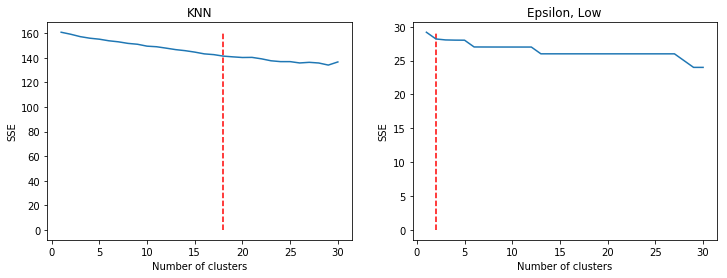

In [77]:
# fig, ax2 = plt.subplots(figsize=(12,4));
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4));
# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12,4));
## knn
ax1.plot(range(1, len(sse_knn_cell)+1), sse_knn_cell);
ax1.set_xlabel('Number of clusters');
ax1.set_ylabel('SSE');
ax1.vlines(x=len(np.unique(kmeans_knn_cell.labels_)), ymin=0, ymax=max(sse_knn_cell), colors='r', linestyle='dashed');
ax1.set_title('KNN');
## epsilon low
ax2.plot(range(1, len(sse_elow_cell)+1), sse_elow_cell);
ax2.set_xlabel('Number of clusters');
ax2.set_ylabel('SSE');
ax2.vlines(x=len(np.unique(kmeans_elow_cell.labels_)), ymin=0, ymax=max(sse_elow_cell), colors='r', linestyle='dashed');
ax2.set_title('Epsilon, Low');
## epsilon high
# ax3.plot(range(1, len(sse_ehigh_cell)+1), sse_ehigh_cell);
# ax3.set_xlabel('Number of clusters');
# ax3.set_ylabel('SSE');
# ax3.vlines(x=len(np.unique(kmeans_ehigh_cell.labels_)), ymin=0, ymax=max(sse_ehigh_cell), colors='r', linestyle='dashed');
# ax3.set_title('Epsilon, High');
plt.savefig('plots/spectral_kmeans_cells.png',bbox_inches='tight');

In [70]:
min_drug = 30

In [71]:
kmeans_knn_drug, sse_knn_drug, silhouette_knn_drug = find_kmeans(proj_knn_drug, 
                                                                 kmeans_kwargs,
                                                                 n_clust=min(proj_knn_drug.shape[1], min_drug))

# kmeans_elow_drug, sse_elow_drug, silhouette_elow_drug = find_kmeans(proj_elow_drug, 
#                                                                     kmeans_kwargs, 
#                                                                     n_clust=min(proj_elow_drug.shape[1], min_drug))

kmeans_ehigh_drug, sse_ehigh_drug, silhouette_ehigh_drug = find_kmeans(proj_ehigh_drug, 
                                                                       kmeans_kwargs, 
                                                                       n_clust=min(proj_ehigh_drug.shape[1], min_drug))

C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDrive\PhD\NYU\Math Tools for DS\projects\project 2\github\src\kmeans.py:15: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  kmeans.fit(mx_input)
C:\Users\jessb\OneDr

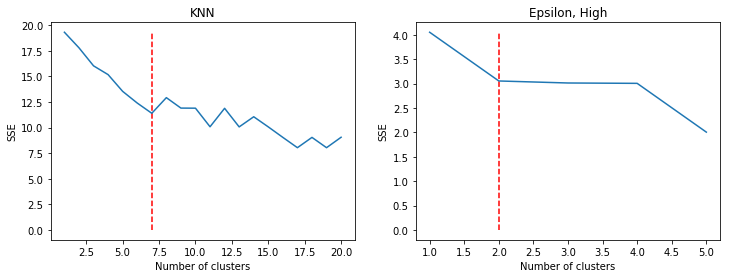

In [72]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4));
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12,4));
## knn
ax1.plot(range(1, len(sse_knn_drug)+1), sse_knn_drug);
ax1.set_xlabel('Number of clusters');
ax1.set_ylabel('SSE');
ax1.vlines(x=len(np.unique(kmeans_knn_drug.labels_)), ymin=0, ymax=max(sse_knn_drug), colors='r', linestyle='dashed');
ax1.set_title('KNN');
## epsilon low
# ax2.plot(range(1, len(sse_elow_drug)+1), sse_elow_drug);
# ax2.set_xlabel('Number of clusters');
# ax2.set_ylabel('SSE');
# ax2.vlines(x=len(np.unique(kmeans_elow_drug.labels_)), ymin=0, ymax=max(sse_elow_drug), colors='r', linestyle='dashed');
# ax2.set_title('Epsilon, Low');
## epsilon high
ax3.plot(range(1, len(sse_ehigh_drug)+1), sse_ehigh_drug);
ax3.set_xlabel('Number of clusters');
ax3.set_ylabel('SSE');
ax3.vlines(x=len(np.unique(kmeans_ehigh_drug.labels_)), ymin=0, ymax=max(sse_ehigh_drug), colors='r', linestyle='dashed');
ax3.set_title('Epsilon, High');

In [73]:
## create dataframe with cell data
pd.DataFrame({'cell':list_cell, 
              'knn_all':kmeans_cell.labels_,
              'knn_knn':kmeans_knn_cell.labels_,
              'knn_elow':kmeans_elow_cell.labels_,
              'lnIC50_mean':np.nanmean(mx_gdsc, axis=1)}).to_csv("../assets/cell.csv", index=False)

In [74]:
## create dataframe with drug data
temp_list = [re.sub(" \(", "\n", string) for string in list_drug]
temp_list = [re.sub("\)", "", string) for string in temp_list]

## create dataframe with cell data
pd.DataFrame({'cell':temp_list, 
              'knn_all':kmeans_drug.labels_,
              'knn_knn':kmeans_knn_drug.labels_,
              'knn_ehigh':kmeans_ehigh_drug.labels_,
              'lnIC50_mean':np.nanmean(mx_gdsc, axis=0)}).to_csv("../assets/drug.csv", index=False)

In [75]:
elbow_cell_knn = len(np.unique(kmeans_knn_cell.labels_))
elbow_cell_elow = len(np.unique(kmeans_elow_cell.labels_))

print('The optimal number of cell clusters using KNN graph and elbow method is %1d' % elbow_cell_knn)
print('The optimal number of cell clusters using epsilon low graph and elbow method is %1d' % elbow_cell_elow)

The optimal number of cell clusters using KNN graph and elbow method is 18
The optimal number of cell clusters using epsilon low graph and elbow method is 2


In [76]:
elbow_drug_knn = len(np.unique(kmeans_knn_drug.labels_))
elbow_drug_ehigh = len(np.unique(kmeans_ehigh_drug.labels_))

print('The optimal number of drug clusters using KNN graph and elbow method is %1d' % elbow_drug_knn)
print('The optimal number of drug clusters using epsilon high graph and elbow method is %1d' % elbow_drug_ehigh)

The optimal number of drug clusters using KNN graph and elbow method is 7
The optimal number of drug clusters using epsilon high graph and elbow method is 2
